In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from numpy import cos
from math import log
from scipy.interpolate import interp1d
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize

In [2]:
def model(t, z, T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (R_L - Rain)
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva 
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (R_L - Rain)
    
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (R_L - Rain)

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (Temp - Tmin)
    
    tau_M_curr = tau_M(T_curr)

    # Taxa de infecção de expostos (1/Duração do ciclo esporogônico)
    def b3(tau_M, Temp):
        return 1/tau_M
    
    b3_curr = b3(tau_M_curr, T_curr)
    
    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de mordida e taxa de nascimento
    def a(Temp):
        return (T_linha - T_curr) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    dShdt = -a_curr * b2 * (I_M / N) * S_H
    dIhdt = a_curr * b2 * (I_M / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H / N) * S_M - mu_curr * E_M - b3_curr * E_M * l_curr
    dImdt = b3_curr * E_M * l_curr - mu_curr * I_M
    
#     print(a_curr * b2)
#     print((I_M / N) * S_H)
#     print('----')
#     print(- gamma * I_H)
#     print(' ')
#     print(dShdt)
#     print(dIhdt)
#     print(' ')
#     print(dSmdt)
#     print(dEmdt)
#     print(dImdt)
#     print(' ')
    
    #print(b_curr - mu_curr*M)
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt] 

In [3]:
T_linha = 26.4
T1= 26.4 
T2= 0.025
omega1= 0.017
phi1= -1.45

R1= 250.083 
R2= 0.565
omega2= 0.02
phi2=1.6

B_E=200
p_ME=0.9
p_ML=0.75
p_MP=0.85
tau_E=1
tau_P=1
c1=0.019
c2=-0.021

D1=36.5
b1=0.1

A=317.925
B=15
C=-48.78

b2=0.3
tau_H=10
DD=105
Tmin=14.5
gamma= 1/1825 
R_L = 312
N = 8558
M = 300000 
E_M0 = 50000
I_H0 = 1000 
I_M0 = 2500
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0 - I_M0

In [4]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

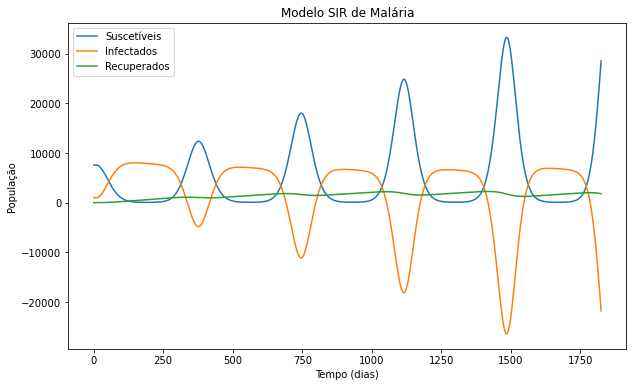

In [5]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

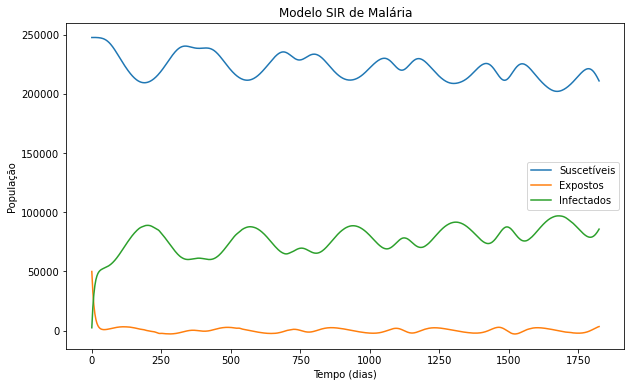

In [6]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

#### Testando a(T) = $\dfrac{T-T'}{D1}$

In [7]:
def model_teste(t, z, T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (R_L - Rain)
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (R_L - Rain)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (R_L - Rain)

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (Temp - Tmin)
    
    tau_M_curr = tau_M(T_curr)

    # Taxa de infecção de expostos (1/Duração do ciclo esporogônico)
    def b3(tau_M, Temp):
        return 1/tau_M
    
    b3_curr = b3(tau_M_curr, T_curr)
    
    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de mordida e probabilidade de transmissão
    def a(Temp):
        return (T_curr - T_linha) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    dShdt = -a_curr * b2 * (I_M / N) * S_H
    dIhdt = a_curr * b2 * (I_M / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H / N) * S_M - mu_curr * E_M - b3_curr * E_M * l_curr
    dImdt = b3_curr * E_M * l_curr - mu_curr * I_M
    
#     print(dSmdt)
#     print(dEmdt)
#     print(dImdt)
#     print(' ')
    
    #print(b_curr - mu_curr*M)
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt]

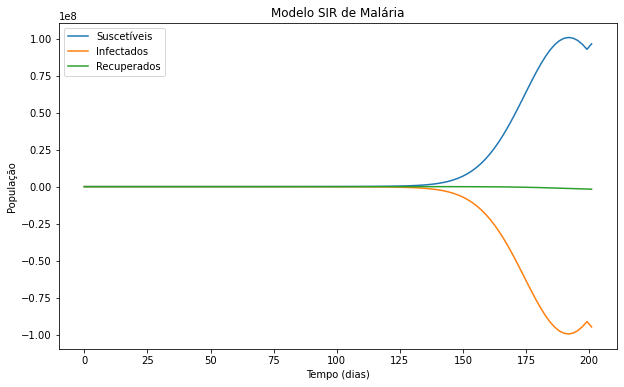

In [8]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model_teste, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

Usando a formulação original de $a(T)$, a população de humanos irá rapidamente tender a $\pm$ infinito. Além disso, é possível notar que a modelagem ficou quebrada, dado que deveria percorrer até $t=1825$ e foi apenas até $t=200$.

#### Modificando $A, \ B$ e $C$:

In [9]:
# Dados originais

# A=317.925
# B=15
# C=-48.78

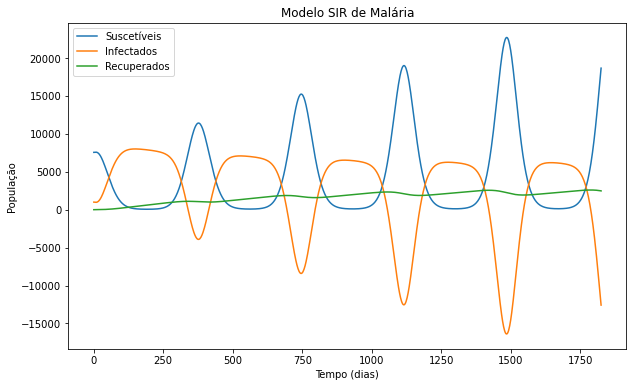

In [10]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 17.925, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

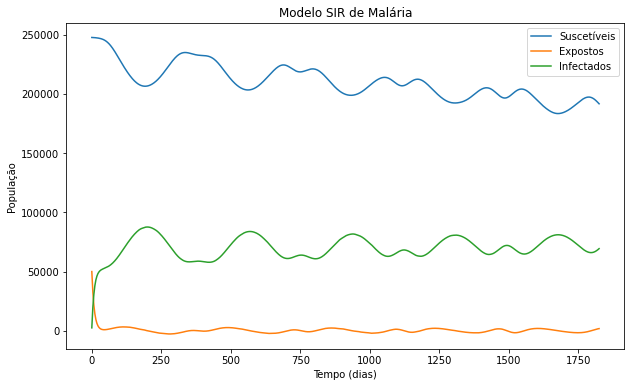

In [11]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

Passando $A$ de 317.925 para 17.925, nota-se que não existe uma diferença muito notável entre a modelagem original e atual.

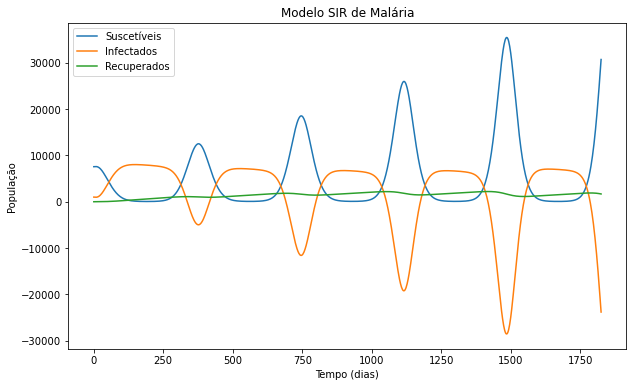

In [12]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, -217.925, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

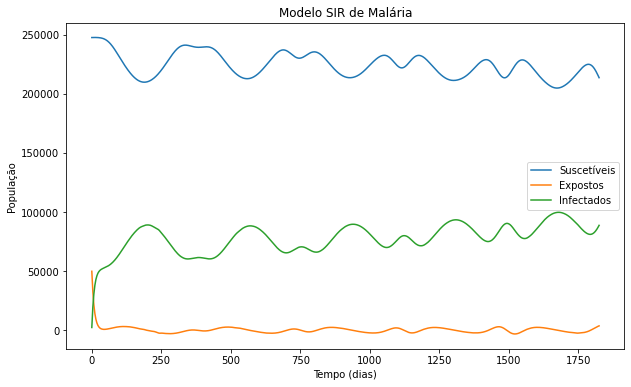

In [13]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

Passando $A$ de 317.925 para -217.925, novamente nota-se que não existe uma diferença muito notável entre a modelagem original e atual.

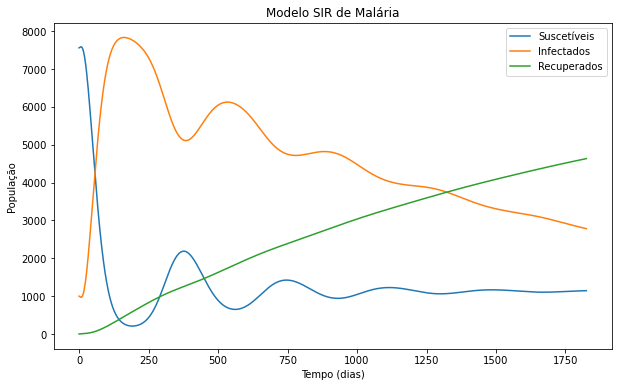

In [14]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 0, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

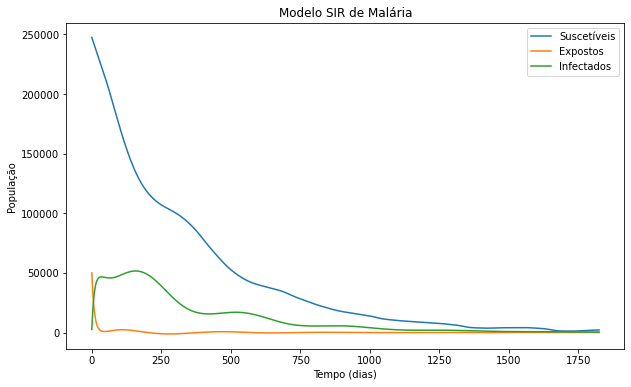

In [15]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

Passando $A$ de 317.925 para 0, por outro lado, percebe-se que a modelagem sim se altera: a população de humanos não oscila em valores negativos, enquanto que a população de mosquitos tende à extinção. Verificando abaixo, é possível ver que valores "grandes" de $A$, especialmente considerando os valores utilizados no artigo, $\mu$ ficará muito pequeno, estabilizando a população de mosquitos. 

In [16]:
Temp = 26.4
A_values = [317.925, 17.925, -217.925, 0]

p = np.exp(-1 / (A*Temp**2 + B*Temp + C))
mu = -log(p)

for A in A_values:
    p = np.exp(-1 / (A * Temp**2 + B * Temp + C))
    mu = -log(p)
    print(f"Para A = {A}, mu = {mu}")

Para A = 317.925000000000, mu = 4.505961269611858e-06
Para A = 17.9250000000000, mu = 7.78802370175753e-05
Para A = -217.925000000000, mu = -6.599014101979344e-06
Para A = 0, mu = 0.0028800184321179124


In [17]:
# Dados do artigo

# A = -0.03 
# B = 1.31 
# C = -4.4

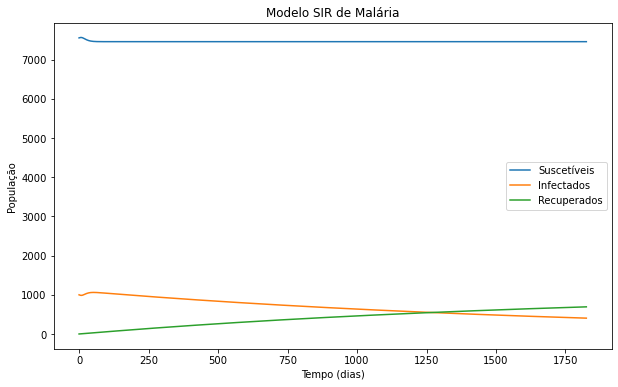

In [18]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, -0.03 , 1.31 , -4.4, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

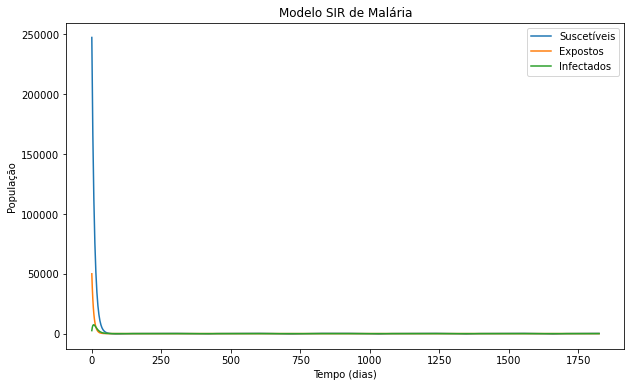

In [19]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

Usando os valores de $A, \ B$ e $C$ originários do artigo, rapidamente a população de mosquitos se extingue, e portanto a população de humanos se equilibra rapidamente.

Modificando $A$ usando $B$ e $C$ do artigo:

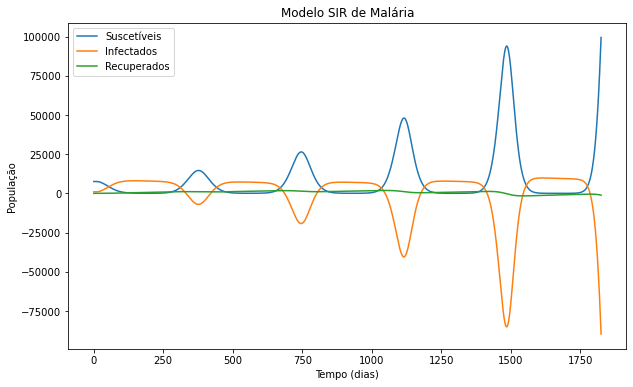

In [20]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, -10, 1.31 , -4.4, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

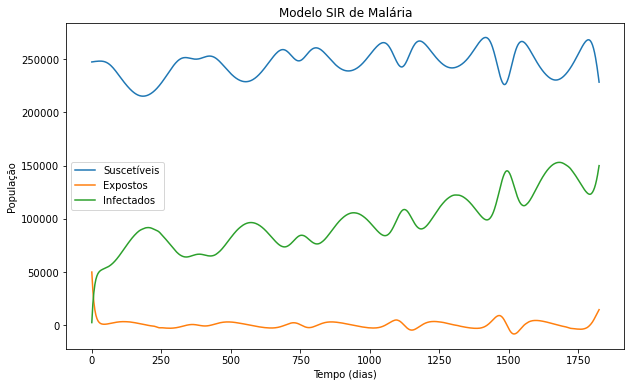

In [21]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [22]:
print(f'População inicial = {S_M[0]+E_M[0]+I_M[0]}')
print(f'População final = {S_M[-1]+E_M[-1]+I_M[-1]}')

População inicial = 300000.0
População final = 393178.06973110663


Diminuindo $A$ sem modificar $B$ e $C$, é possível ver que, ainda que a população de humanos se torne negativa ao longo do tempo, a de mosquitos irá aumentar. De fato, com os parâmetros passados, a população final é de quase 100000 mosquitos a mais.

Aumentando $B$:

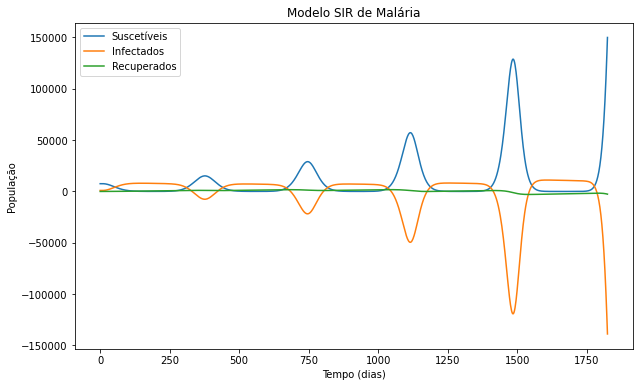

In [23]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, -10, 50.31 , -1.4, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

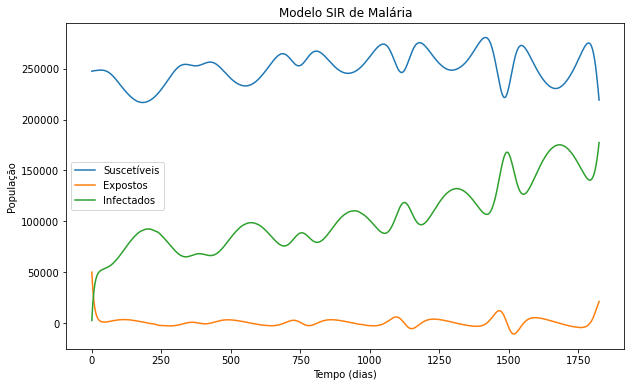

In [24]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [25]:
print(f'População inicial = {S_M[0]+E_M[0]+I_M[0]}')
print(f'População final = {S_M[-1]+E_M[-1]+I_M[-1]}')

População inicial = 300000.0
População final = 417603.8872509836


In [26]:
min(E_M)

-10747.208701272744

Diminuindo $A$ e aumentando $B$, vemos algo bem similar ao caso anterior, com ainda mais mosquitos ao final. Contudo, é possível notar que em alguns pontos, a população de mosquitos expostos se torna negativa.

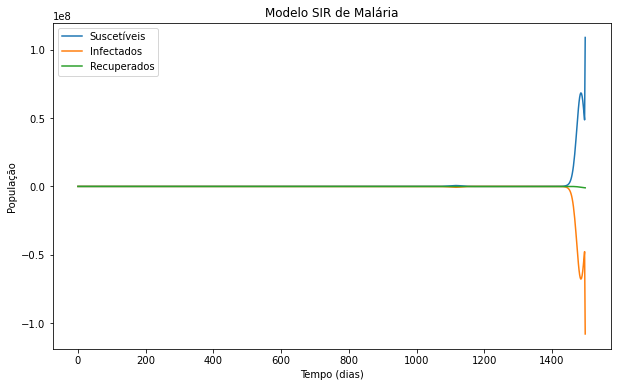

In [27]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, -5, 50.31 , -1.4, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

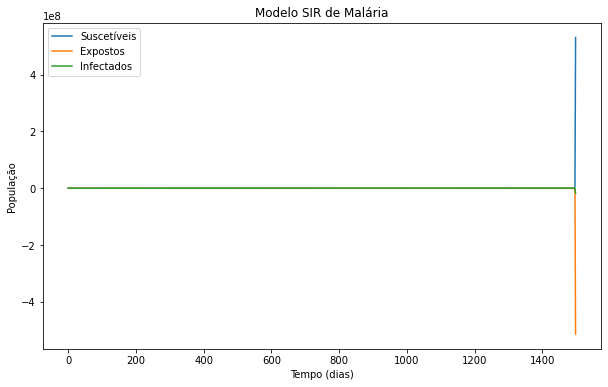

In [28]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [29]:
print(f'População inicial = {S_M[0]+E_M[0]+I_M[0]}')
print(f'População final = {S_M[-1]+E_M[-1]+I_M[-1]}')

População inicial = 300000.0
População final = 603410.6955422759


Aumentando $A$ de -10 para -5, nota-se que esse é um ponto de quebra do modelo, que as populações explodem para $\pm$ infinito ao final do período. 

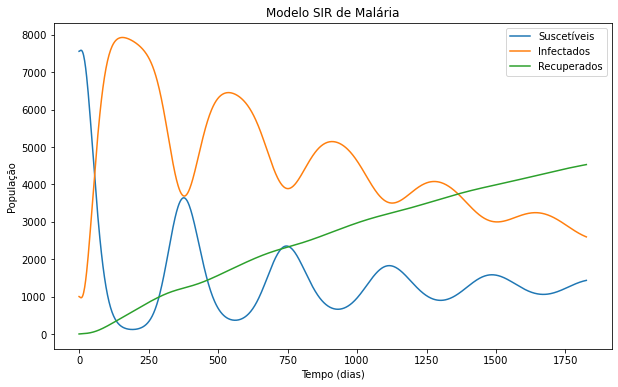

In [30]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, -1, 50.31 , -1.4, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

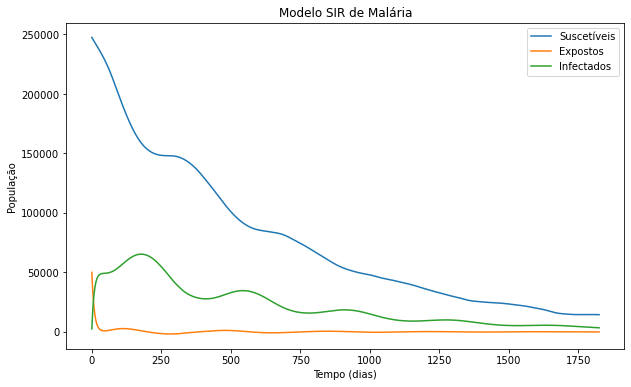

In [31]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [32]:
print(f'População inicial = {S_M[0]+E_M[0]+I_M[0]}')
print(f'População final = {S_M[-1]+E_M[-1]+I_M[-1]}')

População inicial = 300000.0
População final = 17839.567599390233


##### Aumentando $A$ de -5 para -1, a população de mosquitos agora tende à extinção, enquanto a população de humanos tem um "equilíbrio" positivo. Nota-se que essas populações estão inversamente relacionadas: se a população de mosquitos se estabiliza, com a população final próxima da inicial, a de humanos oscilará continuamente, tendendo a valores negativos. O mesmo ocorre se a população de mosquitos aumenta. Agora, caso a população de mosquitos se extingua ao longo do tempo, a população humana se manterá "estável", sem oscilações tendendo a valores negativos.

###### Sendo assim, é interessante buscar formas verificar como a queimada e desmatamento afetam ambas populações. Idealmente, seria possível aplicá-las no modelo de forma a impedir que as populações oscilem para valores negativos.

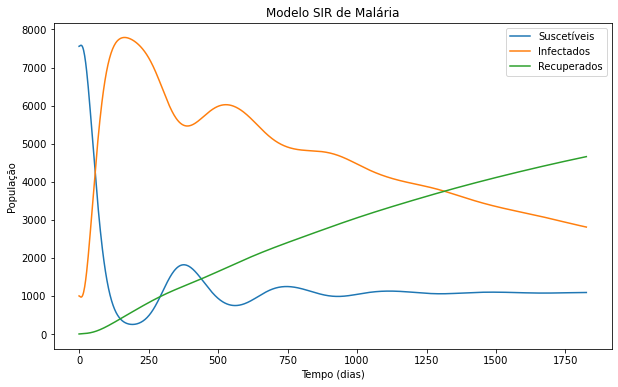

In [33]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, -1.5, 50.31 , -1.4, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

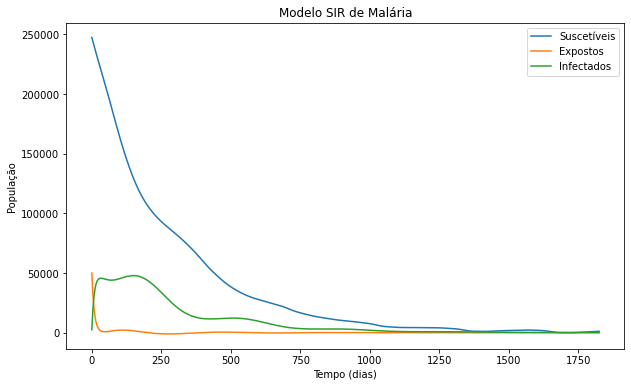

In [34]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

Analisando valores de $A$ que a população humana tende a infinito:

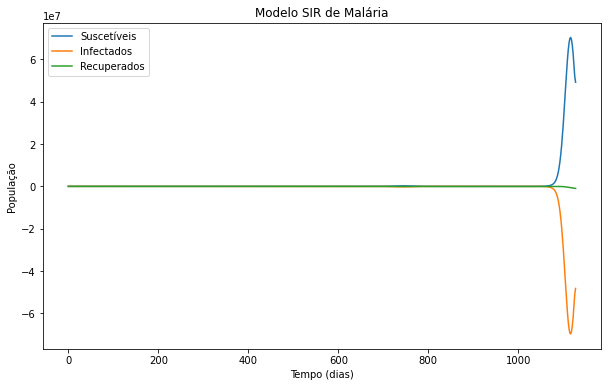

In [35]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, -4, 50.31 , -1.4, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

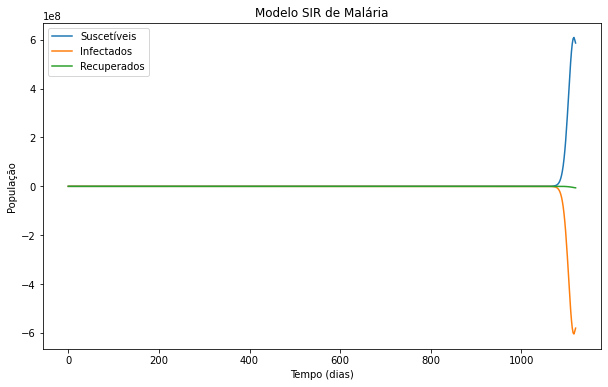

In [36]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, -3.8, 50.31 , -1.4, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

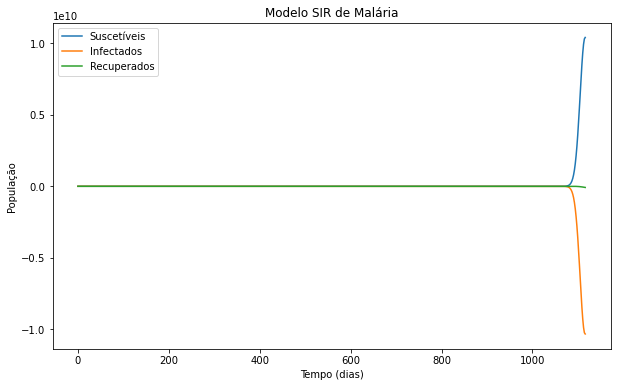

In [37]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, -3.6, 50.31 , -1.4, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

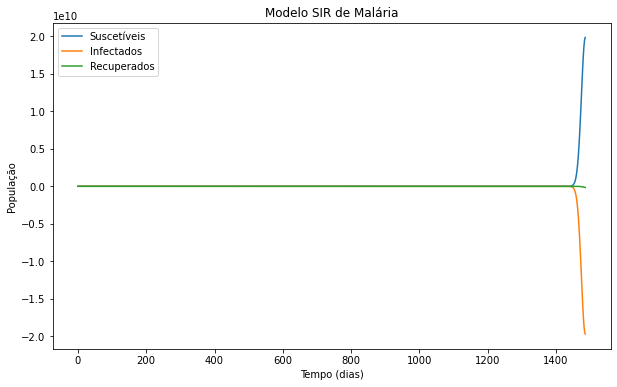

In [38]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, -3.6, 30.31 , -1.4, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

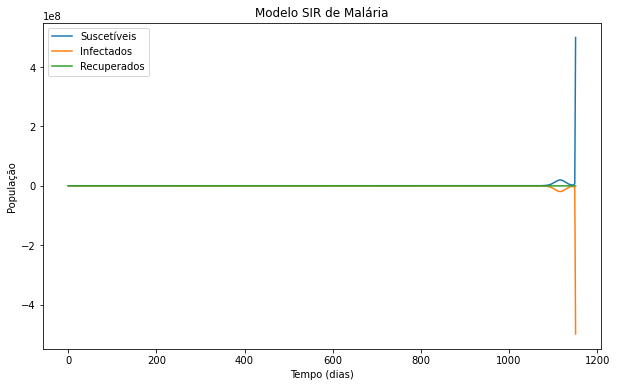

In [39]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, -3.4, 30.31 , -1.4, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

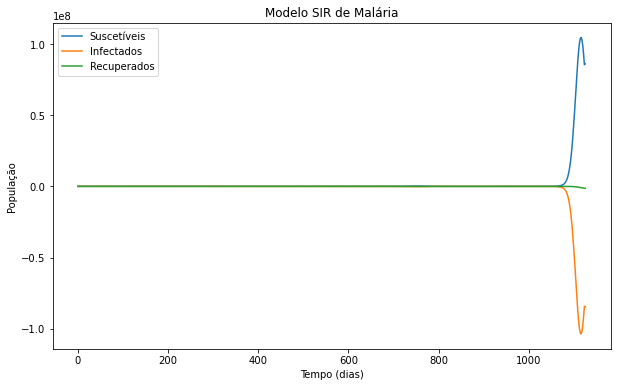

In [40]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, -3.2, 30.31 , -1.4, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

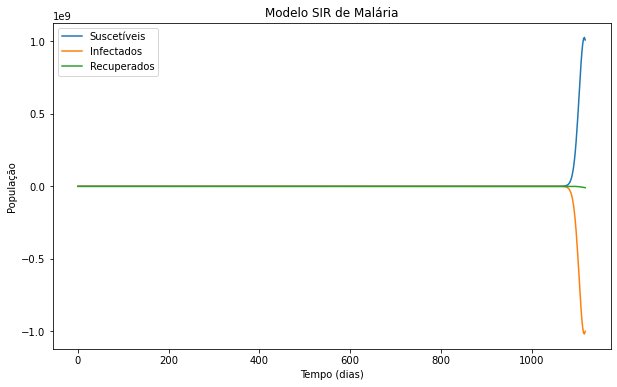

In [41]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, -3.0, 30.31 , -1.4, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

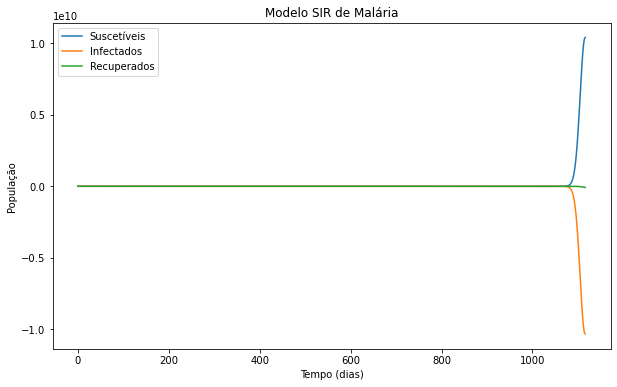

In [42]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, -2.8, 30.31 , -1.4, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [43]:
# Para A=-2.6, o código demora muito tempo para executar

# args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
#                    B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
#                    D1, b1, -2.6, 30.31 , -1.4, b2, tau_H, DD, Tmin, gamma, R_L,
#                    N, M, E_M0, I_H0, I_M0)

# t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
# sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
# #sol

# times = sol.t
# S_H, I_H, R_H, S_M, E_M, I_M = sol.y

# plt.figure(figsize=(10, 6))
# plt.plot(times, S_H, label='Suscetíveis')
# plt.plot(times, I_H, label='Infectados')
# plt.plot(times, R_H, label='Recuperados')

# plt.xlabel('Tempo (dias)')
# plt.ylabel('População')
# plt.title('Modelo SIR de Malária')

# plt.legend()

# plt.show()

In [44]:
# Para A=-2.0, o código demorta muito tempo para executar

# args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
#                    B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
#                    D1, b1, -2.0, 30.31 , -1.4, b2, tau_H, DD, Tmin, gamma, R_L,
#                    N, M, E_M0, I_H0, I_M0)

# t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
# sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
# #sol

# times = sol.t
# S_H, I_H, R_H, S_M, E_M, I_M = sol.y

# plt.figure(figsize=(10, 6))
# plt.plot(times, S_H, label='Suscetíveis')
# plt.plot(times, I_H, label='Infectados')
# plt.plot(times, R_H, label='Recuperados')

# plt.xlabel('Tempo (dias)')
# plt.ylabel('População')
# plt.title('Modelo SIR de Malária')

# plt.legend()

# plt.show()

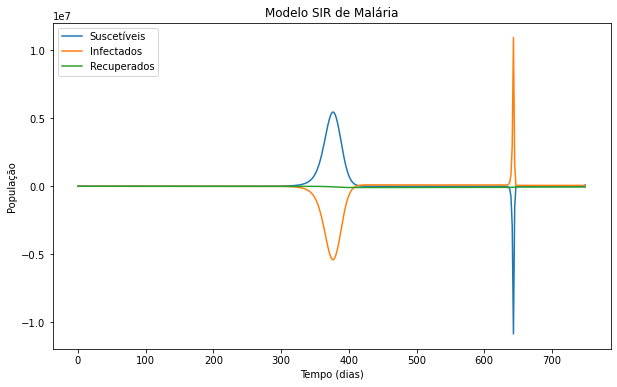

In [45]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, -1.8, 30.31 , -1.4, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

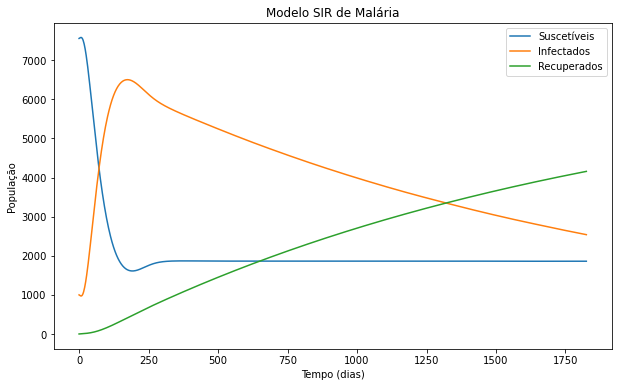

In [46]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, -1.8, 50.31 , -1.4, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [47]:
# args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
#                    B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
#                    D1, b1, -2.0, 50.31 , -1.4, b2, tau_H, DD, Tmin, gamma, R_L,
#                    N, M, E_M0, I_H0, I_M0)

# t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
# sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
# #sol

# times = sol.t
# S_H, I_H, R_H, S_M, E_M, I_M = sol.y

# plt.figure(figsize=(10, 6))
# plt.plot(times, S_H, label='Suscetíveis')
# plt.plot(times, I_H, label='Infectados')
# plt.plot(times, R_H, label='Recuperados')

# plt.xlabel('Tempo (dias)')
# plt.ylabel('População')
# plt.title('Modelo SIR de Malária')

# plt.legend()

# plt.show()

In [48]:
R_L

312

In [49]:
def model(t, z, T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (R_L - Rain)
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (R_L - Rain)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (R_L - Rain)

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (Temp - Tmin)
    
    tau_M_curr = tau_M(T_curr)

    # Taxa de infecção de expostos (1/Duração do ciclo esporogônico)
    def b3(tau_M, Temp):
        return 1/tau_M
    
    b3_curr = b3(tau_M_curr, T_curr)
    
    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de mordida e probabilidade de transmissão
    def a(Temp):
        return (T_linha - T_curr) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    dShdt = -a_curr * b2 * (I_M / N) * S_H
    dIhdt = a_curr * b2 * (I_M / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H / N) * S_M - mu_curr * E_M - b3_curr * E_M * l_curr
    dImdt = b3_curr * E_M * l_curr - mu_curr * I_M
    
    print(p_ER(R_curr))
    print(p_LRT(R_curr,T_curr))
    print(p_PR(R_curr))
    print(' ')
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt] 

0.8524785585819392
0.43865595143373526
0.8051186386607202
 
0.8524783201918472
0.43865583255469454
0.8051184135145223
 
0.8524773046396699
0.43865532612467495
0.8051174543819103
 
0.8524766776622723
0.43865501346690394
0.8051168622365905
 
0.8524757371883477
0.43865454447619606
0.805115974011217
 
0.852471844102234
0.4386526030901216
0.8051122972076653
 
0.8524706119202554
0.43865198863071303
0.8051111334802411
 
0.8524725986485533
0.43865297936400705
0.8051130098347447
 
0.8524712232257348
0.43865229347403695
0.805111710824305
 
0.8524630314026044
0.4386482084028751
0.8051039741024596
 
0.8524642541080144
0.43864881813840084
0.8051051288797912
 
0.8524581229539808
0.4386457606675878
0.8050993383454262
 
0.8524547165848351
0.4386440619834444
0.8050961212190108
 
0.8524547165848351
0.4386440619834444
0.8050961212190108
 
0.8524761746538563
0.4386547626292718
0.8051163871730864
 
0.8524737906654114
0.43865357379357117
0.805114135628444
 
0.8524600153280556
0.4386467043534554
0.8051011255

0.22220694453362072
0.11547260252845858
0.20986211428175283
 
0.23783268231284915
0.12362049778846479
0.22461975551769084
 
0.2623344060742016
0.13640067403344625
0.24776027240341264
 
0.3743459674037136
0.19487986843635619
0.35354896921461837
 
0.412180394543025
0.21464927682084223
0.3892814837350791
 
0.35159572386841054
0.18299601631942697
0.33206262809794324
 
0.3933208167094183
0.20479376968883725
0.3714696602255617
 
0.6434763153972505
0.3356203697233361
0.6077276312085143
 
0.6081352547701276
0.3171293300480761
0.5743499628384537
 
0.7677615934329608
0.4006288214186974
0.7251081715755741
 
0.8321960125392336
0.43427586586133393
0.7859629007314982
 
0.8321960125392336
0.43427586586133393
0.7859629007314982
 
0.2176231887268457
0.11308283735908581
0.20553301157535425
 
0.23070605224178067
0.11990413019071282
0.2178890493394595
 
0.2511237844337728
0.13055259195691313
0.2371724630763409
 
0.3439751813353084
0.17901600543819773
0.3248654490389023
 
0.37545509820684775
0.195459309588

0.8870833480006316
0.46243469855590563
0.8378009397783741
 
0.8843590328985028
0.46105338076612296
0.8352279755152526
 
0.8798627322357979
0.4587643594993557
0.8309814693338091
 
0.8568272414533455
0.44693875531980287
0.8092257280392706
 
0.8483666582942938
0.44257110051073095
0.8012351772779441
 
0.8617700398809197
0.4494856455941941
0.8138939265542018
 
0.8526199336865633
0.4447679716760525
0.8052521595928652
 
0.7912057224509946
0.41288663373753876
0.7472498489814947
 
0.8005148112203911
0.4177375590040991
0.7560417661525917
 
0.7565381322827752
0.3947666335233438
0.7145082360448431
 
0.7369395843547287
0.38446996788427756
0.6959984963350215
 
0.7369395843547287
0.38446996788427756
0.6959984963350215
 
0.8820134893941449
0.4598605237504892
0.833012739983359
 
0.8691474617027709
0.45327890319759095
0.8208614916081723
 
0.76920891048767
0.40140032191929886
0.7264750821272438
 
0.7296567489396697
0.3806252431650393
0.6891202628874658
 
0.7264624873363861
0.3789333412412454
0.6861034602

0.3254791297659185
 
0.29983691366780146
0.15275592035852126
0.28317930735292357
 
0.3306158313013419
0.1684031093683411
0.31224828511793395
 
0.5264357811148622
0.26794168878801244
0.4971893488307031
 
0.49690132749111854
0.2529263717423979
0.4692956981860564
 
0.6404170930802754
0.3259228391428664
0.6048383656869266
 
0.7117162736853505
0.3622417537202149
0.672176480702831
 
0.7117162736853505
0.3622417537202149
0.672176480702831
 
0.22600182109561248
0.1152097478560083
0.21344616436807845
 
0.27413123330435896
0.13968614376551236
0.2589017203430057
 
0.5976706046518725
0.3041699736270077
0.5644666821712129
 
0.7394520541712449
0.3763881328560291
0.6983713844950646
 
0.7526203622118451
0.3831094564386984
0.7108081198667425
 
0.7714443251468427
0.39272432537239993
0.7285863070831291
 
0.8364437032504364
0.4260205351717587
0.7899746086254119
 
0.8523852324808304
0.434226384816279
0.8050304973430065
 
0.8255541438105167
0.42042745690927935
0.7796900247099323
 
0.8447639874476351
0.43030

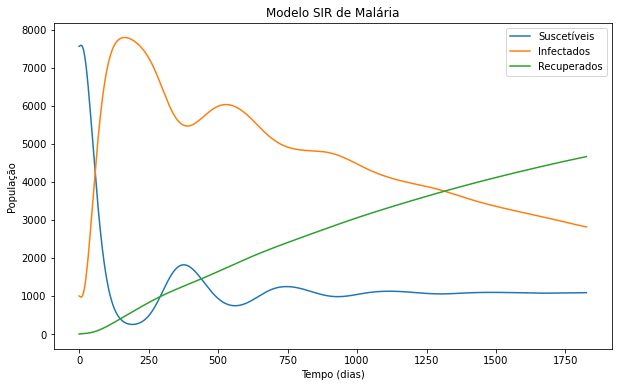

In [50]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, -1.5, 50.31 , -1.4, b2, tau_H, DD, Tmin, gamma, 400,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

0.8524785585819392
0.43865595143373526
0.8051186386607202
 
0.8524783201918472
0.43865583255469454
0.8051184135145223
 
0.8524773046396699
0.43865532612467495
0.8051174543819103
 
0.8524766776622723
0.43865501346690394
0.8051168622365905
 
0.8524757371883477
0.43865454447619606
0.805115974011217
 
0.852471844102234
0.4386526030901216
0.8051122972076653
 
0.8524706119202554
0.43865198863071303
0.8051111334802411
 
0.8524725986485533
0.43865297936400705
0.8051130098347447
 
0.8524712232257348
0.43865229347403695
0.805111710824305
 
0.8524630314026044
0.4386482084028751
0.8051039741024596
 
0.8524642541080144
0.43864881813840084
0.8051051288797912
 
0.8524581229539808
0.4386457606675878
0.8050993383454262
 
0.8524547165848351
0.4386440619834444
0.8050961212190108
 
0.8524547165848351
0.4386440619834444
0.8050961212190108
 
0.8524761746538563
0.4386547626292718
0.8051163871730864
 
0.8524737906654114
0.43865357379357117
0.805114135628444
 
0.8524600153280556
0.4386467043534554
0.8051011255

0.13972915561063845
0.07202424734692728
0.13196642474338074
 
0.18106695725039876
0.09323529494196
0.17100768184759882
 
0.15148044569600833
0.07805658804701134
0.1430648653795634
 
0.0770316313164997
0.03986092656061797
0.07275209624336082
 
0.07608414274805413
0.03934667982308967
0.07185724592871777
 
0.12377954782114758
0.06420001452402592
0.11690290627552827
 
0.19283513448709383
0.10016266784760083
0.18212207146003306
 
0.19283513448709383
0.10016266784760083
0.18212207146003306
 
0.27550842725999025
0.14160325845307484
0.2602024035233241
 
0.2099631100025552
0.10804751563535331
0.198298492780191
 
0.09784123280694071
0.05070270397202545
0.09240560876211065
 
0.22220694453362072
0.11547260252845858
0.20986211428175283
 
0.23783268231284915
0.12362049778846479
0.22461975551769084
 
0.2623344060742016
0.13640067403344625
0.24776027240341264
 
0.3743459674037136
0.19487986843635619
0.35354896921461837
 
0.412180394543025
0.21464927682084223
0.3892814837350791
 
0.35159572386841054
0.

0.7912057224509946
0.41288663373753876
0.7472498489814947
 
0.8005148112203911
0.4177375590040991
0.7560417661525917
 
0.7565381322827752
0.3947666335233438
0.7145082360448431
 
0.7369395843547287
0.38446996788427756
0.6959984963350215
 
0.7369395843547287
0.38446996788427756
0.6959984963350215
 
0.8820134893941449
0.4598605237504892
0.833012739983359
 
0.8691474617027709
0.45327890319759095
0.8208614916081723
 
0.76920891048767
0.40140032191929886
0.7264750821272438
 
0.7296567489396697
0.3806252431650393
0.6891202628874658
 
0.7264624873363861
0.3789333412412454
0.6861034602621424
 
0.7222625062546011
0.3767005203487956
0.6821368114626786
 
0.7130100181180512
0.3716554934841119
0.6733983504448261
 
0.7129438710022182
0.37153609241023544
0.6733358781687615
 
0.7137397939789428
0.3720843219063462
0.6740875832023349
 
0.712801889672421
0.37150513482973063
0.6732017846906198
 
0.7418219005188956
0.38588376474828406
0.7006095727122903
 
0.7340522329165174
0.38197122318613597
0.69327155331

0.7220460122732207
0.37203972884487563
0.6819323449247083
 
0.8750554706068275
0.4475046366590059
0.8264412777953369
 
0.8591354459583278
0.4396841663442195
0.8114056989606429
 
0.7495239243865065
0.3854306898299692
0.7078837063650338
 
0.7171342378241679
0.3697343943270963
0.6772934468339362
 
0.7153554633317418
0.36892971514562894
0.675613493146645
 
0.713557633629113
0.36817044670402355
0.67391554287194
 
0.7174126866395958
0.37085038043455726
0.6775564262707292
 
0.7223428894492132
0.3736146662684393
0.6822127289242569
 
0.7152530162095303
0.3696019276717963
0.675516737531223
 
0.7196830640053699
0.3721326447061045
0.6797006715606271
 
0.7836500379091043
0.4066728936252839
0.7401139246919316
 
0.7710736425643048
0.39994549364287735
0.7282362179773989
 
0.836742346998701
0.4350279385740115
0.7902566610543286
 
0.8694970581244745
0.45255408178289075
0.821191666006448
 
0.8694970581244745
0.45255408178289075
0.821191666006448
 
0.7142628956467899
0.36845619931618373
0.6745816236664125

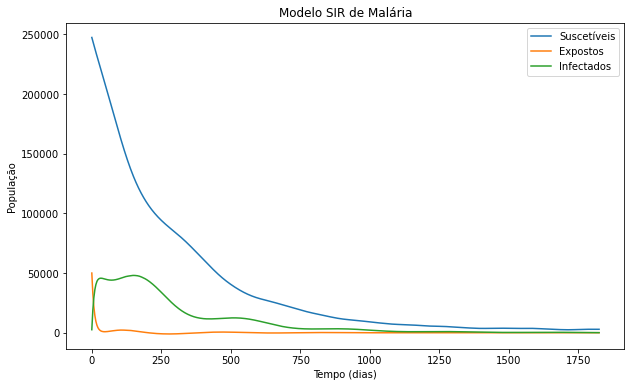

In [51]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

-1.0173153326124469
-0.5234752483130596
-0.9607978141339774
 
-1.0173183610581653
-0.5234768111671383
-0.9608006743327117
 
-1.0173312623105506
-0.5234834689637734
-0.9608128588488533
 
-1.0173392271851673
-0.5234875793025688
-0.9608203812304357
 
-1.0173511745290476
-0.5234937448275593
-0.9608316648329892
 
-1.0174006296251363
-0.5235192665402252
-0.9608783724237396
 
-1.0174162821308426
-0.5235273441469782
-0.9608931553457956
 
-1.0173910444945857
-0.5235143200535839
-0.960869319800442
 
-1.0174085166860771
-0.523523336724046
-0.9608858213146284
 
-1.0175125749917397
-0.5235770368987747
-0.9609840986033096
 
-1.0174970437166737
-0.5235690218502497
-0.9609694301768585
 
-1.0175749226194777
-0.5236092119363601
-0.961042982473951
 
-1.017618189380534
-0.5236315401320126
-0.96108384552606
 
-1.017618189380534
-0.5236315401320126
-0.96108384552606
 
-1.0173456171805073
-0.52349087691213
-0.9608264162260345
 
-1.0173759019949604
-0.5235065056407192
-0.9608550185507958
 
-1.017550885747268


 
-4.682930885142565
-2.402153944346494
-4.4227680581902
 
-4.8954813905721215
-2.5123799281156693
-4.623510202207003
 
-5.689326922408604
-2.925732844401954
-5.373253204497013
 
-5.904095079629195
-3.0381798141444185
-5.5760897974275725
 
-5.548251577004724
-2.852041245710547
-5.240015378282238
 
-5.800058935373842
-2.9836659499400637
-5.477833438964184
 
-6.702439677526979
-3.463086991160009
-6.3300819176643675
 
-6.641589932269991
-3.429416757275619
-6.272612713810545
 
-6.661918541209313
-3.450829178068869
-6.291811955586573
 
-6.371029491478161
-3.305499171536554
-6.017083408618262
 
-6.371029491478161
-3.305499171536554
-6.017083408618262
 
-4.423733783129649
-2.2679399304463796
-4.177970795178001
 
-4.513921523409921
-2.3146158972111013
-4.263148105442703
 
-4.647588190512349
-2.3838406446010327
-4.389388846594996
 
-5.175199114602458
-2.657695301761137
-4.887688052680099
 
-5.331708449757455
-2.7391474375757516
-5.03550242477093
 
-5.0766451095235
-2.606459985023817
-4.79460927

-0.2416554598318252
-0.1257818453579753
-0.22823015650783493
 
-0.027053734468606472
-0.014088689084665484
-0.02555074922035056
 
0.7105381834029119
0.3707197549638879
0.6710638398805278
 
0.8369210926047934
0.43674287950530505
0.7904254763489713
 
0.8449027875756427
0.4409038326526112
0.7979637438214403
 
0.8552311268907573
0.4462820326327009
0.8077182865079373
 
0.8816116356275041
0.4599323893215867
0.8326332114259759
 
0.8859781412722382
0.46215141495739576
0.8367571334237803
 
0.8781607001572466
0.4581626623208905
0.8293739945929551
 
0.883992224655808
0.4611460034027753
0.8348815455082629
 
0.8922430950442255
0.46482788291746824
0.8426740342084351
 
0.8929268995290133
0.465305015654421
0.8433198495551792
 
0.8809353349150886
0.45836866451212993
0.8319944829753614
 
0.8584045660581144
0.4461857504873185
0.8107154234993301
 
0.8584045660581144
0.4461857504873185
0.8107154234993301
 
0.8506603709109782
0.4439029842405165
0.8034014614159237
 
0.8712558312747
0.45460014741583465
0.8228

-5.910432671646925
-3.0383755033729116
-5.582075300999873
 
-6.605175573751924
-3.3855174983534613
-6.23822137521015
 
-6.6534383203999825
-3.409017966916162
-6.283802858155538
 
-6.70626109820924
-3.434252957232686
-6.333691037197615
 
-6.66983645061317
-3.408661947012611
-6.299289981134659
 
-6.573357854829371
-3.357417707925483
-6.2081713073388505
 
-6.709028238597702
-3.4299608002735638
-6.336304447564495
 
-6.626203544699282
-3.385363649110107
-6.258081125549322
 
-5.207337510931485
-2.652586715996731
-4.918040982546401
 
-5.503028164905977
-2.8041110617086282
-5.197304377966756
 
-3.8512741503223955
-1.9602164616754165
-3.6373144753044846
 
-2.8499872444042884
-1.4504354907175083
-2.6916546197151607
 
-2.8499872444042884
-1.4504354907175083
-2.6916546197151607
 
-6.541234801620903
-3.354085558413654
-6.177832868197519
 
-6.569654854175723
-3.368087432056514
-6.204674028943737
 
-6.608306011424581
-3.3870490595114666
-6.241177899678771
 
-6.716329407248186
-3.438929033667489
-6.34

 
0.18780165026607482
0.09559717464065684
0.17736822525129287
 
0.334135557243339
0.17006439474976243
0.3155724707298201
 
0.7996837014936499
0.40714621587429944
0.7552568291884469
 
0.8667756503993304
0.44164644337964204
0.8186214475993675
 
0.8703120819519665
0.4434897912715656
0.8219614107324126
 
0.8749399281800196
0.44591330317949546
0.8263321543922408
 
0.8872556643309681
0.4524991963901785
0.8379636829792475
 
0.8894321785802376
0.4537187713018123
0.8400192797702243
 
0.8855771930906854
0.4515790417572043
0.8363784601412028
 
0.8884338768789108
0.4531545542450438
0.8390764392745268
 
0.8924251834333964
0.45603391841927376
0.8428460065759854
 
0.8929175081619266
0.4561459568141779
0.8433109799307084
 
0.8857355849890927
0.4532133151030072
0.8365280524896985
 
0.8740144732959976
0.44766034643768365
0.825458113668442
 
0.8740144732959976
0.44766034643768365
0.825458113668442
 
0.872883569827817
0.4448345753210249
0.8243900381707159
 
0.8822976557346764
0.4498099524958019
0.83328111

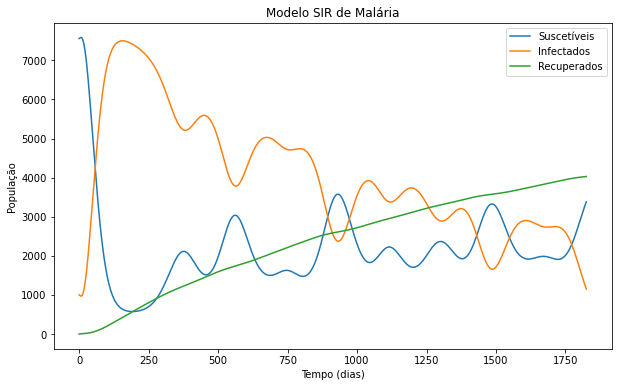

In [52]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, -1.5, 50.31 , -1.4, b2, tau_H, DD, Tmin, gamma, 200,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

-1.0173153326124469
-0.5234752483130596
-0.9607978141339774
 
-1.0173183610581653
-0.5234768111671383
-0.9608006743327117
 
-1.0173312623105506
-0.5234834689637734
-0.9608128588488533
 
-1.0173392271851673
-0.5234875793025688
-0.9608203812304357
 
-1.0173511745290476
-0.5234937448275593
-0.9608316648329892
 
-1.0174006296251363
-0.5235192665402252
-0.9608783724237396
 
-1.0174162821308426
-0.5235273441469782
-0.9608931553457956
 
-1.0173910444945857
-0.5235143200535839
-0.960869319800442
 
-1.0174085166860771
-0.523523336724046
-0.9608858213146284
 
-1.0175125749917397
-0.5235770368987747
-0.9609840986033096
 
-1.0174970437166737
-0.5235690218502497
-0.9609694301768585
 
-1.0175749226194777
-0.5236092119363601
-0.961042982473951
 
-1.017618189380534
-0.5236315401320126
-0.96108384552606
 
-1.017618189380534
-0.5236315401320126
-0.96108384552606
 
-1.0173456171805073
-0.52349087691213
-0.9608264162260345
 
-1.0173759019949604
-0.5235065056407192
-0.9608550185507958
 
-1.017550885747268


-1.6616946565014006
-0.8478035449889655
-1.5693782866957668
 
-1.3773454514454408
-0.7024309646778668
-1.3008262596984719
 
-1.5726369873094528
-0.8022588311463741
-1.4852682657922607
 
-2.856395079895792
-1.4601288064338223
-2.697706464346026
 
-2.6550148597482477
-1.356729411543237
-2.507514034206678
 
-3.6771595589706476
-1.882424260007732
-3.472872916805611
 
-4.241106254128022
-2.17349610159072
-4.005489240009798
 
-4.241106254128022
-2.17349610159072
-4.005489240009798
 
-0.9057246828207978
-0.461600573521282
-0.8554066448863087
 
-1.2141235134809987
-0.6190433341808698
-1.1466722071764983
 
-3.359887391840593
-1.719009264456322
-3.173226981182782
 
-4.537866878816577
-2.327012823638595
-4.2857631633267665
 
-4.682930885142565
-2.402153944346494
-4.4227680581902
 
-4.8954813905721215
-2.5123799281156693
-4.623510202207003
 
-5.689326922408604
-2.925732844401954
-5.373253204497013
 
-5.904095079629195
-3.0381798141444185
-5.5760897974275725
 
-5.548251577004724
-2.852041245710547


-2.3666745379974365
-1.2262204693182144
-2.235192619219801
 
-1.996494580829068
-1.0352186981477622
-1.885578215227453
 
-0.22374946508196608
-0.11646665953530234
-0.21131893924407905
 
-0.43193660985497984
-0.22472421970686735
-0.40794013152970315
 
0.4008646379565981
0.20898144196999863
0.37859438029234266
 
0.6552563368714641
0.3418299813383916
0.6188532070452715
 
0.6552563368714641
0.3418299813383916
0.6188532070452715
 
-3.8490577169297606
-1.988058589189633
-3.635221177100329
 
-3.7438107451908715
-1.9341386568670496
-3.5358212593469336
 
-3.585414775276655
-1.8529379022872126
-3.3862250655390627
 
-2.9298967139536694
-1.5162612864254876
-2.7671246742895765
 
-2.724938030864915
-1.4107943308589554
-2.5735525847057525
 
-3.0562981646015643
-1.5812580617616605
-2.886503822123699
 
-2.8263640343146017
-1.4629973549214956
-2.6693438101860125
 
-1.539255270040629
-0.7988964051970535
-1.453741088371705
 
-1.7187900499837458
-0.891740921844675
-1.6233017138735375
 
-0.8787897880892205


-5.910432671646925
-3.0383755033729116
-5.582075300999873
 
-6.605175573751924
-3.3855174983534613
-6.23822137521015
 
-6.6534383203999825
-3.409017966916162
-6.283802858155538
 
-6.70626109820924
-3.434252957232686
-6.333691037197615
 
-6.66983645061317
-3.408661947012611
-6.299289981134659
 
-6.573357854829371
-3.357417707925483
-6.2081713073388505
 
-6.709028238597702
-3.4299608002735638
-6.336304447564495
 
-6.626203544699282
-3.385363649110107
-6.258081125549322
 
-5.207337510931485
-2.652586715996731
-4.918040982546401
 
-5.503028164905977
-2.8041110617086282
-5.197304377966756
 
-3.8512741503223955
-1.9602164616754165
-3.6373144753044846
 
-2.8499872444042884
-1.4504354907175083
-2.6916546197151607
 
-2.8499872444042884
-1.4504354907175083
-2.6916546197151607
 
-6.541234801620903
-3.354085558413654
-6.177832868197519
 
-6.569654854175723
-3.368087432056514
-6.204674028943737
 
-6.608306011424581
-3.3870490595114666
-6.241177899678771
 
-6.716329407248186
-3.438929033667489
-6.34

0.4670127591588729
0.23767659625192306
0.44106760587226884
 
0.7432812055406394
0.3783447357728273
0.7019878052328259
 
0.7143993774480262
0.3636190059299302
0.6747105231453578
 
0.8257798541365654
0.42051000196648985
0.7799031955734227
 
0.8584883359462485
0.43734650632223737
0.8107945395047901
 
0.8584883359462485
0.43734650632223737
0.8107945395047901
 
0.18780165026607482
0.09559717464065684
0.17736822525129287
 
0.334135557243339
0.17006439474976243
0.3155724707298201
 
0.7996837014936499
0.40714621587429944
0.7552568291884469
 
0.8667756503993304
0.44164644337964204
0.8186214475993675
 
0.8703120819519665
0.4434897912715656
0.8219614107324126
 
0.8749399281800196
0.44591330317949546
0.8263321543922408
 
0.8872556643309681
0.4524991963901785
0.8379636829792475
 
0.8894321785802376
0.4537187713018123
0.8400192797702243
 
0.8855771930906854
0.4515790417572043
0.8363784601412028
 
0.8884338768789108
0.4531545542450438
0.8390764392745268
 
0.8924251834333964
0.45603391841927376
0.8428

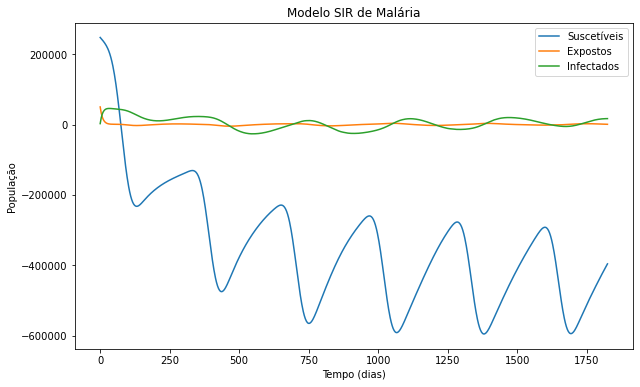

In [53]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

Notavelmente, se $R_L$ é muito baixo, as probabilidades de sobrevivência ficam muito baixas, e acabam tomando valores negativos em alguns pontos. A taxa de nascimentos portanto será baixa ou negativa, explicando o comportamento da população suscetível.

0.8524785585819392
0.43865595143373526
0.8051186386607202
 
0.8524783201920286
0.43865583255478513
0.8051184135146936
 
0.8524773046406243
0.4386553261251509
0.8051174543828117
 
0.8524766776637042
0.4386550134676178
0.8051168622379427
 
0.8524757371904953
0.438654544477267
0.8051159740132454
 
0.8524718441073451
0.4386526030926704
0.8051122972124924
 
0.8524706119263045
0.4386519886337296
0.8051111334859541
 
0.8524725986530899
0.4386529793662693
0.8051130098390292
 
0.8524712232313184
0.4386522934768214
0.8051117108295784
 
0.8524630314144244
0.43864820840876945
0.8051039741136229
 
0.8524642541189037
0.438648818143831
0.8051051288900755
 
0.8524581229695378
0.4386457606753457
0.8050993383601188
 
0.8524547166029854
0.43864406199249567
0.8050961212361527
 
0.8524547166029854
0.43864406199249567
0.8050961212361527
 
0.8524761746556709
0.43865476263017655
0.8051163871748002
 
0.8524737906690407
0.4386535737953811
0.8051141356318717
 
0.8524600153421718
0.4386467043604948
0.805101125600

0.3006645061480926
0.15446673649326031
0.28396092247319854
 
0.2782789203350966
0.1430203420782428
0.2628189803164801
 
0.16390722836413749
0.08443345201670474
0.15480127123279652
 
0.17854165547845438
0.09194024810369329
0.16862267461854022
 
0.11555860256329022
0.059610448879729
0.10913868019866296
 
0.09274985451894444
0.04789053085276103
0.08759708482344752
 
0.09274985451894444
0.04789053085276103
0.08759708482344752
 
0.36181128808557633
0.18570054983500903
0.341710660969711
 
0.32061858605205623
0.16466443708913275
0.30280644238249754
 
0.13213196377279518
0.06812326882521308
0.12479129911875098
 
0.08693826315095596
0.044904878647068734
0.08210835964256952
 
0.0844857228366752
0.043645422417607126
0.07979207156797102
 
0.08137924602301864
0.042051150384841696
0.07685817679951759
 
0.075921341781968
0.03927109019510654
0.07170348946074753
 
0.07669565316919083
0.0396842687487546
0.07243478354868021
 
0.07604189770458386
0.039325713434818936
0.07181734783210697
 
0.07616099810668

0.8025990396746054
0.4087126539305313
0.7580102041371272
 
0.8025990396746054
0.4087126539305313
0.7580102041371272
 
0.8002130076762077
0.4106887371562629
0.7557567294719738
 
0.8050379632961066
0.4130814426330991
0.7603136320018784
 
0.8122970430349895
0.4166807573443613
0.7671694295330457
 
0.8417436224433783
0.43126303073117705
0.7949800878631904
 
0.8505293863435494
0.4356030203506494
0.8032777537689076
 
0.8361957375451956
0.4285191824910511
0.7897404187926845
 
0.8462176489476213
0.43347400744732323
0.79920555733942
 
0.8916802131908944
0.45571683044501016
0.842142423569178
 
0.8870248043622074
0.45348183571689815
0.8377456485643069
 
0.8999784724828096
0.45941520239563644
0.8499796684559867
 
0.8944188634009561
0.4562484807894559
0.8447289265453474
 
0.8944188634009561
0.4562484807894559
0.8447289265453474
 
0.8089193210412915
0.41500606242137966
0.7639793587612196
 
0.8272358832814417
0.42408375036108903
0.7812783342102504
 
0.8989021669471695
0.45906589763814565
0.84896315767

 
0.08125036332384389
0.04159121033203398
0.07673645425029699
 
0.0813915563800615
0.041663948549870565
0.07686980324783585
 
0.08116480348896286
0.04154713058218541
0.07665564773957602
 
0.08132127987789588
0.04162774481713183
0.07680343099579053
 
0.08230034343404825
0.04213203915962618
0.07772810213215665
 
0.0821490918034908
0.04205414329602022
0.07758525336996352
 
0.08292557488166688
0.042454003808794535
0.07831859849935204
 
0.08337643567975078
0.04268614483835227
0.07874441147532017
 
0.08337643567975078
0.04268614483835227
0.07874441147532017
 
0.08076863525636632
0.04134300652841163
0.07628148885323484
 
0.08103103444251371
0.04147821065136472
0.0765293103068185
 
0.08268110646580254
0.04232812046376038
0.07808771166214684
 
0.08354594372553381
0.04277341584810435
0.07890450240744859
 
0.08363140384577258
0.04281741372416442
0.07898521474322964
 
0.08376047634332294
0.04288386335845884
0.07910711654647166
 
0.08430601202453421
0.043164700504525304
0.07962234468983784
 
0.0844

0.1204417153958676
0.06175690885067009
0.11375050898498602
 
0.1204417153958676
0.06175690885067009
0.11375050898498602
 
0.11746422959246194
0.06022463347920584
0.11093843905954737
 
0.11779027410693035
0.06039241689652679
0.11124636998987865
 
0.11969753765956051
0.06137392846908683
0.11304767445625157
 
0.12067527802808706
0.06187711006847307
0.11397109591541552
 
0.12079227408623906
0.06193732147490461
0.11408159219255909
 
0.12096803646094591
0.06202777701204114
0.11424758999089336
 
0.12169900611553222
0.062403972765398955
0.11493795022022486
 
0.12193150229375868
0.06252362918653874
0.1151575299441054
 
0.1215569039192077
0.062330838857612
0.11480374259036281
 
0.12181608868475559
0.062464230355088114
0.11504852820226913
 
0.12337387792289682
0.06326597877131236
0.11651977359384696
 
0.1231398306602168
0.0631455193316927
0.11629872895687143
 
0.12431884017364346
0.06375233982128742
0.11741223794177436
 
0.12497969727786025
0.06409248283131336
0.11803638076242355
 
0.124979697277

0.1482183554956448
0.07605755240243126
0.1399840024125534
 
0.14845364845541792
0.0761787417009921
0.14020622354122803
 
0.14981980628704028
0.07688240786129687
0.14149648371553802
 
0.15047361651304308
0.07721917576039031
0.14211397115120733
 
0.15053631974926923
0.07725147361052218
0.14217319087430982
 
0.15063041865288218
0.07729994318941398
0.1422620620610554
 
0.15102049242400126
0.07750086847559741
0.14263046506711227
 
0.15114413789401093
0.07756455820637978
0.1427472413443436
 
0.15094482006516877
0.07746188979156246
0.14255899672821493
 
0.15108278425135913
0.07753295494064559
0.1426892962373947
 
0.1519067732583288
0.07795739660847413
0.1434675080773105
 
0.15178353612209688
0.0778939157527167
0.143351117448647
 
0.15240237696504177
0.07821269011381818
0.14393557824476164
 
0.15274714228630865
0.0783902865679232
0.14426118993706924
 
0.15274714228630865
0.0783902865679232
0.14426118993706924
 
0.15058664168381505
0.07727739401210602
0.14222071714582532
 
0.15082534242631143
0

0.16988040471627125
0.08721834356860683
0.16044260445425615
 
0.17007643738976724
0.08731937739332178
0.16062774642366906
 
0.1712125036777569
0.08790490947223233
0.16170069791788147
 
0.17175492798439496
0.08818448368400182
0.16221298754081745
 
0.1718069062905121
0.08821127437802347
0.1622620781632614
 
0.17188489637692794
0.08825147216002226
0.16233573546709862
 
0.1722080162512105
0.0884180161537225
0.16264090423725436
 
0.17231037940607416
0.08847077699833508
0.16273758055018112
 
0.17214535485205915
0.08838571878890662
0.16258172402694474
 
0.172259589734729
0.08844459855517088
0.162689612527244
 
0.17294112203250764
0.0887958830369208
0.16333328191959054
 
0.17283927042155112
0.08874338486234838
0.16323708873146492
 
0.17335044330863736
0.0890068643300085
0.16371986312482412
 
0.17363492419966017
0.08915349919683413
0.16398853952190123
 
0.17363492419966017
0.08915349919683413
0.16398853952190123
 
0.17184861567100898
0.08823277228562353
0.16230147035595288
 
0.17204639820464088

0.19263763754678553
0.09895121653313739
0.18193554657196406
 
0.19263763754678553
0.09895121653313739
0.18193554657196406
 
0.19098806577298397
0.09810048476379228
0.18037761767448485
 
0.1911708748391632
0.09819476262543711
0.1805502706814319
 
0.1922294395862114
0.09874069319226184
0.18155002627586628
 
0.19272734940075564
0.09899748471749517
0.18202027443404697
 
0.19277221592453003
0.099020624321002
0.1820626483731672
 
0.1928395289528472
0.09905534061374242
0.1821262217888001
 
0.19311833262546385
0.0991991326813788
0.1823895363684936
 
0.19320662970303382
0.09924467185321809
0.18247292805286527
 
0.19306427537676585
0.09917125274223183
0.1823384823002788
 
0.19316282082979003
0.09922207743474355
0.18243155300591277
 
0.1937504162299103
0.09952513209571927
0.18298650421713747
 
0.19366263910618312
0.09947986036069265
0.18290360360028401
 
0.19410304787332763
0.09970700579675622
0.1833195452136983
 
0.19434800977810412
0.09983334874686295
0.18355089812376496
 
0.19434800977810412
0

0.2048174870957548
 
0.21734272437641072
0.11169728934373062
0.2052681285777212
 
0.21738835476735174
0.111720839917531
0.2053112239469433
 
0.21745681103510012
0.1117561713496813
0.20537587708870564
 
0.21774031433368102
0.11190249292360716
0.20564363020403206
 
0.21783008786094796
0.11194882704103135
0.20572841631311747
 
0.21768535034527692
0.11187412484440634
0.20559171977053928
 
0.21778554715835086
0.11192583857700622
0.20568635009399797
 
0.21838284132336452
0.11223411808307525
0.20625046124984425
 
0.21829363140330452
0.11218807411532822
0.20616620743645422
 
0.2187411724574452
0.11241906494226907
0.20658888509869824
 
0.21899004045699255
0.11254751529646757
0.2068239270982707
 
0.21899004045699255
0.11254751529646757
0.2068239270982707
 
0.21742496679726594
0.11173973599372806
0.20534580197519559
 
0.21759853525417733
0.11182931782852448
0.20550972774005635
 
0.21860298467415462
0.11234774130931263
0.2064583744144793
 
0.2190809172061767
0.11259442051641375
0.20690975513916687

0.24010102050265916
0.12344707217112001
0.22676207491917802
 
0.2402775521181696
0.12353824303398574
0.22692879922271567
 
0.24129886340926449
0.12406571472988775
0.22789337099763862
 
0.2417858627846416
0.12431723837533651
0.22835331485216148
 
0.24183265774301246
0.1243414070480814
0.22839751009062284
 
0.24190285915353224
0.12437766475232497
0.22846381142278047
 
0.24219356447186913
0.12452780934153113
0.22873836644565415
 
0.2422856100982312
0.12457534967756917
0.22882529842610722
 
0.24213720737626515
0.12449870171660159
0.2286851402998059
 
0.24223994261370482
0.1245517630163853
0.22878216802405454
 
0.24285226375926428
0.1248680214821683
0.229360471328194
 
0.24276082086994877
0.12482079168488631
0.22927410859939604
 
0.24321952385148404
0.1250577107378669
0.22970732808195712
 
0.2434745553455083
0.12518943527378754
0.2299481911596467
 
0.2434745553455083
0.12518943527378754
0.2299481911596467
 
0.24187020341216972
0.12436079866886277
0.22843296988927136
 
0.24204818877222506
0.

0.2680888815463524
0.13790731621193572
0.25319505479377724
 
0.2682026680814352
0.137966128776239
0.2533025198546888
 
0.26888079564431633
0.13831663481412962
0.25394297366407653
 
0.2687795320213589
0.13826429392319167
0.25384733579795005
 
0.26928747495363203
0.1385268397192141
0.2543270596784302
 
0.2695698576023186
0.13867279943432734
0.25459375440218973
 
0.2695698576023186
0.13867279943432734
0.25459375440218973
 
0.26779314193890286
0.13775445889964516
0.25291574516451937
 
0.26799028475766046
0.13785635488728284
0.25310193560445704
 
0.2691306549684023
0.1384457821246707
0.25417895191460216
 
0.2696739967558907
0.13872662782751188
0.25469210804723
 
0.269726073311364
0.13875354569075185
0.25474129146073266
 
0.2698041968644353
0.13879392706714122
0.2548150748164111
 
0.27012769175533224
0.13896113967577056
0.2551205977689249
 
0.27023011407367936
0.13901408148910344
0.2552173299584749
 
0.270064979998774
0.13892872421774785
0.2550613699988421
 
0.27017929862691664
0.13898781510

0.15333487428424283
0.2813732007986182
 
0.29792456555147817
0.15333487428424283
0.2813732007986182
 
0.29574509746786504
0.15220746786255654
0.2793148142752059
 
0.29598694123088487
0.15233256664538547
0.27954322227361345
 
0.29738582568359234
0.15305618575384072
0.2808643909233927
 
0.29805708981998436
0.15340342933898116
0.28149836260776295
 
0.29812336081426666
0.15343771154518077
0.2815609518801407
 
0.2982227783741554
0.15348914069966466
0.2816548462422578
 
0.29863444731734395
0.1537021004358712
0.28204364468860255
 
0.29876478642859194
0.15376952644419623
0.2821667427381146
 
0.29855464245819124
0.15366081653267966
0.2819682734327361
 
0.29870012045328176
0.15373607391747016
0.2821056693169883
 
0.2995671082489073
0.15418458270975605
0.28292449112396795
 
0.2994376435397995
0.15411760753351142
0.2828022188986995
 
0.3000870403604562
0.15445355841667027
0.2834155381182086
 
0.3004480575094977
0.1546403251872231
0.28375649875897
 
0.3004480575094977
0.1546403251872231
0.283756498

0.3345505251005606
0.17229122900753877
0.3159643848171961
 
0.33572540434181025
0.17289962792904992
0.3170739929894874
 
0.33587814673942507
0.17297872544822074
0.31721824969834583
 
0.33610730217236034
0.1730973940250189
0.3174346742738958
 
0.3370563975613443
0.17358889296670768
0.31833104214126956
 
0.3373569609400771
0.1737445455629144
0.3186149075545172
 
0.33687238298675476
0.17349359808243456
0.3181572505986017
 
0.33720783639759977
0.17366731835248092
0.3184740677088442
 
0.339207840147262
0.1747030881962584
0.3203629601390808
 
0.3389090950224941
0.1745483692136984
0.3200808119656888
 
0.34040791879187543
0.17532461745127767
0.3214963677478823
 
0.34124149026137585
0.1757563423028504
0.3222836296912994
 
0.34124149026137585
0.1757563423028504
0.3222836296912994
 
0.3356433554343767
0.1728571391122874
0.316996502354689
 
0.33575505779464443
0.17291498391768098
0.3171019990282752
 
0.33592263373649855
0.1730017630648427
0.3172602651955819
 
0.33661658076132206
0.1733611276313294

0.408179067700184
0.21045774165342204
0.38550245282795154
 
0.4082756166595727
0.21050784136703973
0.38559363795626306
 
0.4084204469955513
0.21058299477435893
0.38573042216246506
 
0.40902004353499777
0.21089413263040735
0.38629670778305336
 
0.4092098430465287
0.2109926229861065
0.38647596287727704
 
0.40890382247205614
0.21083382370818102
0.38618694344583077
 
0.4091156789870829
0.21094375950771013
0.38638703015446707
 
0.41037776177443264
0.21159868858181557
0.3875789972314086
 
0.41018935239936366
0.21150091633979326
0.38740105504384337
 
0.41113422633527563
0.21199124989333556
0.38829343598331584
 
0.411659301502567
0.21226373848023172
0.3887893403079799
 
0.411659301502567
0.21226373848023172
0.3887893403079799
 
0.40835307769057605
0.2105480363634521
0.3856667955966552
 
0.40872022766368477
0.210738553905093
0.38601354834903556
 
0.41084256255724755
0.2118398922764282
0.38801797574851155
 
0.41185266061391274
0.21236408352345693
0.3889719572464731
 
0.4119493453677329
0.2124142

0.4155740230351572
0.2142954179998856
0.3924865773109818
 
0.41557031290162133
0.21429349239090095
0.39248307329597565
 
0.4155728814551004
0.21429482550452836
0.39248549915203923
 
0.415588178665265
0.2143027649633326
0.3924999465171946
 
0.4155858954944345
0.21430157996659624
0.392497790189188
 
0.4155973439834368
0.21430752188898672
0.39250860265102355
 
0.41560370427467075
0.21431082296797582
0.39251460959274453
 
0.41560370427467075
0.21431082296797582
0.39251460959274453
 
0.415560446401487
0.21428837154620925
0.39247375493473763
 
0.41556107833765643
0.2142886995294361
0.3924743517633421
 
0.41556202624216776
0.21428919150442102
0.3924752470064917
 
0.4155659499897392
0.21429122798147476
0.392478952768087
 
0.4155671918435383
0.2142918725201222
0.3924801256300084
 
0.41556518951296717
0.2142908332839215
0.3924782345400245
 
0.415566575741676
0.21429155275505413
0.3924795437560272
 
0.415574831517529
0.21429583761308935
0.39248734087766624
 
0.4155735993106831
0.21429519808119946

0.4156110941920965
0.2143146584379311
0.39252158895920225
 
0.41561108535835545
0.21431465385309606
0.3925215806162245
 
0.41561112965325564
0.21431467684276798
0.392521622450297
 
0.4156111542615324
0.21431468961480732
0.3925216456914472
 
0.4156111542615324
0.21431468961480732
0.3925216456914472
 
0.4156109992293873
0.21431460915095868
0.3925214992721991
 
0.4156110164551815
0.21431461809138647
0.3925215155410047
 
0.41561111598198963
0.21431466974718996
0.3925216095385457
 
0.415611163322327
0.21431469431748626
0.3925216542488643
 
0.4156111678527243
0.21431469666882577
0.3925216585275729
 
0.4156111746483194
0.21431470019583457
0.392521664945635
 
0.41561120277792474
0.2143147147954926
0.39252169151248445
 
0.415611211680847
0.21431471941623367
0.3925216999207999
 
0.4156111973260184
0.2143147119658771
0.39252168636346174
 
0.415611207263977
0.21431471712381647
0.39252169574931156
 
0.4156112664500424
0.21431474784221116
0.3925217516472622
 
0.4156112576163006
0.21431474325737573
0

0.4156113540848958
0.21431479332592437
0.3925218344135127
 
0.4156113538941465
0.21431479322692282
0.3925218342333605
 
0.4156113540262056
0.21431479329546332
0.392521834358083
 
0.4156113548126816
0.21431479370365536
0.3925218351008659
 
0.41561135469529625
0.21431479364273073
0.392521834990002
 
0.4156113552838964
0.21431479394822242
0.3925218355459021
 
0.41561135561089707
0.21431479411794038
0.3925218358547361
 
0.41561135561089707
0.21431479411794038
0.3925218358547361
 
0.4156113533868423
0.2143147929636248
0.3925218337542399
 
0.41561135341931627
0.2143147929804793
0.39252183378490973
 
0.4156113534680268
0.2143147930057607
0.3925218338309141
 
0.4156113536696565
0.21431479311040938
0.3925218340213422
 
0.4156113537334706
0.2143147931435298
0.39252183408161107
 
0.41561135363057816
0.21431479309012713
0.39252183398443485
 
0.41561135370181107
0.21431479312709806
0.3925218340517104
 
0.4156113541260493
0.21431479334728362
0.39252183445237987
 
0.4156113540627296
0.214314793314419

 
0.41561135599480004
0.21431479431719133
0.39252183621731107
 
0.4156113559952579
0.21431479431742897
0.3925218362177435
 
0.41561135599451965
0.2143147943170458
0.3925218362170463
 
0.41561135599503085
0.21431479431731115
0.39252183621752906
 
0.4156113559980717
0.2143147943188894
0.392521836220401
 
0.4156113559976183
0.21431479431865405
0.3925218362199728
 
0.4156113559998946
0.2143147943198355
0.3925218362221226
 
0.41561135600115906
0.21431479432049177
0.3925218362233168
 
0.41561135600115906
0.21431479432049177
0.3925218362233168
 
0.4156113559925575
0.21431479431602743
0.3925218362151931
 
0.41561135599268323
0.2143147943160927
0.3925218362153119
 
0.4156113559928717
0.2143147943161905
0.39252183621548986
 
0.4156113559936515
0.21431479431659525
0.39252183621622644
 
0.41561135599389815
0.21431479431672326
0.3925218362164593
 
0.4156113559935003
0.21431479431651673
0.39252183621608355
 
0.4156113559937762
0.2143147943166599
0.39252183621634407
 
0.4156113559954163
0.21431479431

0.41561135600259913
0.2143147943212392
0.39252183622467685
 
0.41561135600260135
0.21431479432124034
0.392521836224679
 
0.4156113560026025
0.21431479432124095
0.39252183622468007
 
0.41561135600260773
0.21431479432124362
0.392521836224685
 
0.4156113560026085
0.21431479432124403
0.3925218362246857
 
0.41561135600260773
0.21431479432124362
0.392521836224685
 
0.4156113560026085
0.21431479432124403
0.3925218362246857
 
0.4156113560026194
0.21431479432124967
0.392521836224696
 
0.4156113560026183
0.21431479432124909
0.39252183622469494
 
0.4156113560026269
0.2143147943212536
0.3925218362247031
 
0.41561135600263177
0.2143147943212561
0.3925218362247077
 
0.41561135600263177
0.2143147943212561
0.3925218362247077
 
0.41561135600260135
0.21431479432124034
0.392521836224679
 
0.415611356002604
0.2143147943212417
0.3925218362246815
 
0.41561135600262467
0.2143147943212524
0.392521836224701
 
0.4156113560026329
0.21431479432125672
0.39252183622470876
 
0.41561135600263516
0.21431479432125788
0

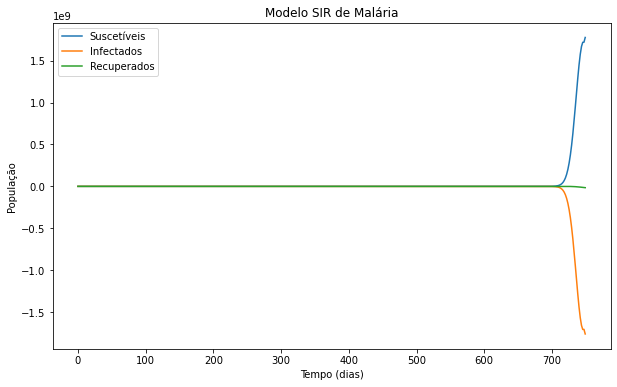

In [54]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, -1.5, 10.31 , -1.4, b2, tau_H, DD, Tmin, gamma, 400,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

0.8524785585819392
0.43865595143373526
0.8051186386607202
 
0.8524783201920286
0.43865583255478513
0.8051184135146936
 
0.8524773046406243
0.4386553261251509
0.8051174543828117
 
0.8524766776637042
0.4386550134676178
0.8051168622379427
 
0.8524757371904953
0.438654544477267
0.8051159740132454
 
0.8524718441073451
0.4386526030926704
0.8051122972124924
 
0.8524706119263045
0.4386519886337296
0.8051111334859541
 
0.8524725986530899
0.4386529793662693
0.8051130098390292
 
0.8524712232313184
0.4386522934768214
0.8051117108295784
 
0.8524630314144244
0.43864820840876945
0.8051039741136229
 
0.8524642541189037
0.438648818143831
0.8051051288900755
 
0.8524581229695378
0.4386457606753457
0.8050993383601188
 
0.8524547166029854
0.43864406199249567
0.8050961212361527
 
0.8524547166029854
0.43864406199249567
0.8050961212361527
 
0.8524761746556709
0.43865476263017655
0.8051163871748002
 
0.8524737906690407
0.4386535737953811
0.8051141356318717
 
0.8524600153421718
0.4386467043604948
0.805101125600

0.1982774893275471
0.10205888442345136
0.18726207325379446
 
0.08003069465597976
0.04135971123650103
0.07558454495286976
 
0.08759723296412701
0.04524335130372826
0.08273072002167549
 
0.08858551308261563
0.045885876336482584
0.08366409568913696
 
0.13018719845010768
0.06753501660101813
0.12295457631399058
 
0.13018719845010768
0.06753501660101813
0.12295457631399058
 
0.3789848959666719
0.19446451409970852
0.35793017952407896
 
0.3664657321599851
0.1880761430608002
0.3461065248177637
 
0.3478946448700506
0.17859601077046733
0.3285671645994922
 
0.2745839511419948
0.14113037451753394
0.2593292871896617
 
0.2529079063233681
0.1300395190162839
0.23885746708318092
 
0.2882599990443927
0.14812475264359865
0.27224555465303746
 
0.26355556012200393
0.1354883171537884
0.2489135845596703
 
0.14241537999073273
0.07340335851744666
0.134503414435692
 
0.15715887620316019
0.08097078702959762
0.14842782752520683
 
0.09734022406320111
0.050249286924042263
0.0919324338374677
 
0.08045387423179484
0.0

0.7471156695469438
0.38441131587763394
0.7056092434610023
 
0.7418237735054237
0.3818100506685956
0.7006113416440111
 
0.7715351827092082
0.39647366871270745
0.7286721170031409
 
0.7906530554635456
0.4059480072658399
0.7467278857155708
 
0.7906530554635456
0.4059480072658399
0.7467278857155708
 
0.7130825490099514
0.36816264178076
0.6734668518427317
 
0.715131534972963
0.36899160378638846
0.6754020052522427
 
0.7615875584160767
0.3915517348349026
0.7192771385040724
 
0.8047056637089981
0.4129166596689887
0.7599997935029426
 
0.811797857283326
0.41643327181008866
0.7666979763231411
 
0.8224082203554278
0.4216922420816656
0.7767188747801261
 
0.8631748909769912
0.44183397341871217
0.8152207303671583
 
0.8739763534202231
0.4471336141622194
0.8254221115635438
 
0.8559347973300739
0.4382691612564223
0.8083828641450697
 
0.8687897265007549
0.44459221760386564
0.8205236305840462
 
0.897279802456463
0.4578085171990636
0.8474309245422148
 
0.8997634123168287
0.4592513913054791
0.849776556077004

 
0.08598972685696289
0.044031312790598014
0.08121251980935383
 
0.08064665315734723
0.041280148171762523
0.07616628353749459
 
0.08071414536537365
0.041314927914767
0.07623002617840843
 
0.08081627293734449
0.041367553598606166
0.07632647999638088
 
0.08125036332384389
0.04159121033203398
0.07673645425029699
 
0.0813915563800615
0.041663948549870565
0.07686980324783585
 
0.08116480348896286
0.04154713058218541
0.07665564773957602
 
0.08132127987789588
0.04162774481713183
0.07680343099579053
 
0.08230034343404825
0.04213203915962618
0.07772810213215665
 
0.0821490918034908
0.04205414329602022
0.07758525336996352
 
0.08292557488166688
0.042454003808794535
0.07831859849935204
 
0.08337643567975078
0.04268614483835227
0.07874441147532017
 
0.08337643567975078
0.04268614483835227
0.07874441147532017
 
0.08076863525636632
0.04134300652841163
0.07628148885323484
 
0.08103103444251371
0.04147821065136472
0.0765293103068185
 
0.08268110646580254
0.04232812046376038
0.07808771166214684
 
0.0835

 
0.1179537462591421
0.060476540651801455
0.1114007603558564
 
0.11814274041855148
0.06057379862811492
0.11157925483974304
 
0.11927655871377275
0.06115728104288697
0.11265008322967426
 
0.11910643583488612
0.06106973177814682
0.11248941162183686
 
0.11996263991806601
0.06151035867063641
0.11329804881150676
 
0.1204417153958676
0.06175690885067009
0.11375050898498602
 
0.1204417153958676
0.06175690885067009
0.11375050898498602
 
0.11746422959246194
0.06022463347920584
0.11093843905954737
 
0.11779027410693035
0.06039241689652679
0.11124636998987865
 
0.11969753765956051
0.06137392846908683
0.11304767445625157
 
0.12067527802808706
0.06187711006847307
0.11397109591541552
 
0.12079227408623906
0.06193732147490461
0.11408159219255909
 
0.12096803646094591
0.06202777701204114
0.11424758999089336
 
0.12169900611553222
0.062403972765398955
0.11493795022022486
 
0.12193150229375868
0.06252362918653874
0.1151575299441054
 
0.1215569039192077
0.062330838857612
0.11480374259036281
 
0.1218160886

0.14876790428300984
0.07634060271786154
0.1405030207117315
 
0.14857142318374086
0.0762394027272669
0.14031745522908856
 
0.14870742328646316
0.07630945117803686
0.1404458997705485
 
0.1495197331714974
0.07672784689059678
0.14121308132863641
 
0.14939823721824172
0.07666526743085009
0.1410983351505616
 
0.15000835424509953
0.07697952542370612
0.14167455678703844
 
0.15034828054095561
0.0771546165568071
0.14199559828868027
 
0.15034828054095561
0.0771546165568071
0.14199559828868027
 
0.1482183554956448
0.07605755240243126
0.1399840024125534
 
0.14845364845541792
0.0761787417009921
0.14020622354122803
 
0.14981980628704028
0.07688240786129687
0.14149648371553802
 
0.15047361651304308
0.07721917576039031
0.14211397115120733
 
0.15053631974926923
0.07725147361052218
0.14217319087430982
 
0.15063041865288218
0.07729994318941398
0.1422620620610554
 
0.15102049242400126
0.07750086847559741
0.14263046506711227
 
0.15114413789401093
0.07756455820637978
0.1427472413443436
 
0.15094482006516877


 
0.16991636422744422
0.08723687679649583
0.1604765662148084
 
0.17023662756717814
0.08740193869612838
0.16077903714677932
 
0.1703380873024017
0.08745423079656492
0.160874860230046
 
0.17017451955493465
0.08736992845652723
0.16072037957966048
 
0.17028774579081232
0.08742828488417217
0.16082731546910048
 
0.17096327928443417
0.08777645673824179
0.16146531932418784
 
0.17086232211977484
0.08772442268389886
0.1613699708908984
 
0.17136901317226272
0.08798557651557633
0.16184851244047035
 
0.17165100758555324
0.08813092108643353
0.1621148404974669
 
0.17165100758555324
0.08813092108643353
0.1621148404974669
 
0.16988040471627125
0.08721834356860683
0.16044260445425615
 
0.17007643738976724
0.08731937739332178
0.16062774642366906
 
0.1712125036777569
0.08790490947223233
0.16170069791788147
 
0.17175492798439496
0.08818448368400182
0.16221298754081745
 
0.1718069062905121
0.08821127437802347
0.1622620781632614
 
0.17188489637692794
0.08825147216002226
0.16233573546709862
 
0.17220801625121

0.18918782400234133
0.09717209562100963
0.17867738933554458
 
0.19035510767934352
0.09777406105326716
0.17977982391937997
 
0.19090145627385086
0.09805581889503265
0.18029581981419243
 
0.1909495087337476
0.0980806002834683
0.18034120269298382
 
0.19102160291607714
0.09811778042207
0.18040929164296174
 
0.19132022633615936
0.09827178620749864
0.18069132487303932
 
0.19141480591918775
0.09832056298418995
0.1807806500347884
 
0.1912623241376411
0.0982419248343281
0.1806366394633277
 
0.1913678796252902
0.09829636204248597
0.18073633075721848
 
0.1919973429140725
0.09862099317392485
0.18133082386329066
 
0.19190330390196628
0.09857249434377321
0.18124200924074588
 
0.19237515721938658
0.09881584507113635
0.18168764848497618
 
0.19263763754678553
0.09895121653313739
0.18193554657196406
 
0.19263763754678553
0.09895121653313739
0.18193554657196406
 
0.19098806577298397
0.09810048476379228
0.18037761767448485
 
0.1911708748391632
0.09819476262543711
0.1805502706814319
 
0.1922294395862114
0.

0.11152213443954977
0.20494760952734967
 
0.2172514806894516
0.11165019711287015
0.20518195398448205
 
0.2172514806894516
0.11165019711287015
0.20518195398448205
 
0.21569108987713498
0.11084487544709909
0.20370825155062744
 
0.21586413451528605
0.11093418242089922
0.2038716825977701
 
0.21686557457197572
0.11145102657945385
0.2048174870957548
 
0.21734272437641072
0.11169728934373062
0.2052681285777212
 
0.21738835476735174
0.111720839917531
0.2053112239469433
 
0.21745681103510012
0.1117561713496813
0.20537587708870564
 
0.21774031433368102
0.11190249292360716
0.20564363020403206
 
0.21783008786094796
0.11194882704103135
0.20572841631311747
 
0.21768535034527692
0.11187412484440634
0.20559171977053928
 
0.21778554715835086
0.11192583857700622
0.20568635009399797
 
0.21838284132336452
0.11223411808307525
0.20625046124984425
 
0.21829363140330452
0.11218807411532822
0.20616620743645422
 
0.2187411724574452
0.11241906494226907
0.20658888509869824
 
0.21899004045699255
0.1125475152964675

0.2434745553455083
0.12518943527378754
0.2299481911596467
 
0.24187020341216972
0.12436079866886277
0.22843296988927136
 
0.24204818877222506
0.12445272499059816
0.22860106717376807
 
0.2430779003084596
0.12498456216602515
0.22957357251354518
 
0.24356814042619707
0.12523777249142745
0.23003657706918607
 
0.24361494003593942
0.12526194480019578
0.23008077670060942
 
0.24368514828447704
0.12529820788685062
0.23014708449089494
 
0.24397588013383162
0.12544837384198898
0.23042166457084096
 
0.24406793356196455
0.12549592063365345
0.23050860391963315
 
0.24391951811937865
0.1254192621910419
0.23036843377941313
 
0.24402226224262666
0.12547233078816133
0.230465469895814
 
0.24463462892705853
0.12578862891121165
0.23104381620888856
 
0.24454318004299652
0.125741393608152
0.23095744781838554
 
0.2450019102535032
0.12597833881049614
0.23139069301719747
 
0.24525695382082952
0.12611007630048687
0.23163156749745006
 
0.24525695382082952
0.12611007630048687
0.23163156749745006
 
0.243652489383143

 
0.2691306549684023
0.1384457821246707
0.25417895191460216
 
0.2696739967558907
0.13872662782751188
0.25469210804723
 
0.269726073311364
0.13875354569075185
0.25474129146073266
 
0.2698041968644353
0.13879392706714122
0.2548150748164111
 
0.27012769175533224
0.13896113967577056
0.2551205977689249
 
0.27023011407367936
0.13901408148910344
0.2552173299584749
 
0.270064979998774
0.13892872421774785
0.2550613699988421
 
0.27017929862691664
0.13898781510593136
0.2551693375920879
 
0.270860591564488
0.13933997693721126
0.2558127809220164
 
0.27075885588228915
0.13928738910666022
0.25571669722216195
 
0.2712691644935858
0.13955117244316637
0.2561986553550532
 
0.27155285993782663
0.1396978189402169
0.2564665899412807
 
0.27155285993782663
0.1396978189402169
0.2564665899412807
 
0.2697678561519077
0.13877514286186837
0.25478075303235725
 
0.2699659219248887
0.13887752160964842
0.25496781515128375
 
0.2711116147233726
0.13946973307441035
0.25604985834985183
 
0.27165896572033643
0.139752666937

0.3029961624338857
0.15595860250973412
0.2861630422986698
 
0.3029961624338857
0.15595860250973412
0.2861630422986698
 
0.3007024865714419
0.15477195135530683
0.2839967928730284
 
0.3009570007459045
0.15490362249419448
0.28423716737113197
 
0.3024291869460951
0.15566526621136376
0.28562756544908985
 
0.30313678084242623
0.15603135502379986
0.2862958485734025
 
0.3032070995915609
0.15606773632656687
0.286362260725363
 
0.3033125896386145
0.1561223145839386
0.286461890214247
 
0.30374940584364724
0.1563483155096518
0.28687443885233344
 
0.3038877076189001
0.15641987096148136
0.2870050571956278
 
0.30366472573164366
0.15630450331166815
0.2867944631909967
 
0.3038190910313819
0.1563843696405177
0.28694025264074957
 
0.30473905260286543
0.15686035134505572
0.28780910523603953
 
0.3046016764941016
0.15678927312526025
0.2876793611333181
 
0.30529076040592085
0.15714580699741243
0.28833016260559186
 
0.30567384429301026
0.1573440186071291
0.2886919640545096
 
0.30567384429301026
0.157344018607

 
0.35077271843602303
0.18069348842996802
0.3312853451895773
 
0.351759691066522
0.1812048123180891
0.33221748600727075
 
0.352072230909984
0.18136673372037718
0.33251266252609596
 
0.3515683396852229
0.1811056772276803
0.332036765258266
 
0.351917165365594
0.18128639680903952
0.332366211734172
 
0.3539966636302293
0.18236377970106862
0.3343301823174387
 
0.3536860695068817
0.18220285767451228
0.33403684342316603
 
0.3552442509225283
0.18301018166731414
0.33550845920461003
 
0.3561107373126997
0.18345914029162666
0.33632680746199406
 
0.3561107373126997
0.18345914029162666
0.33632680746199406
 
0.35066186003380745
0.180636056564837
0.3311806455874847
 
0.3512661046920109
0.18094909677162258
0.33175132109801025
 
0.3547631249660861
0.18276089722745312
0.3350540624679702
 
0.35650610808385647
0.18366400011859774
0.3367002131903089
 
0.35670383912913
0.183766454540885
0.33688695917751166
 
0.3570004926196671
0.18392016673235687
0.3371671319185745
 
0.3582291792515427
0.18455682921274658
0

 
0.40902004353499777
0.21089413263040735
0.38629670778305336
 
0.4092098430465287
0.2109926229861065
0.38647596287727704
 
0.40890382247205614
0.21083382370818102
0.38618694344583077
 
0.4091156789870829
0.21094375950771013
0.38638703015446707
 
0.41037776177443264
0.21159868858181557
0.3875789972314086
 
0.41018935239936366
0.21150091633979326
0.38740105504384337
 
0.41113422633527563
0.21199124989333556
0.38829343598331584
 
0.411659301502567
0.21226373848023172
0.3887893403079799
 
0.411659301502567
0.21226373848023172
0.3887893403079799
 
0.40835307769057605
0.2105480363634521
0.3856667955966552
 
0.40872022766368477
0.210738553905093
0.38601354834903556
 
0.41084256255724755
0.2118398922764282
0.38801797574851155
 
0.41185266061391274
0.21236408352345693
0.3889719572464731
 
0.4119493453677329
0.2124142589500686
0.389063270625081
 
0.4120943789797529
0.21248952571278867
0.38920024681421095
 
0.4126948116525533
0.21280113005797952
0.3897673221163003
 
0.41288487401709745
0.2128997

0.21431082296797582
0.39251460959274453
 
0.41560370427467075
0.21431082296797582
0.39251460959274453
 
0.415560446401487
0.21428837154620925
0.39247375493473763
 
0.41556107833765643
0.2142886995294361
0.3924743517633421
 
0.41556202624216776
0.21428919150442102
0.3924752470064917
 
0.4155659499897392
0.21429122798147476
0.392478952768087
 
0.4155671918435383
0.2142918725201222
0.3924801256300084
 
0.41556518951296717
0.2142908332839215
0.3924782345400245
 
0.415566575741676
0.21429155275505413
0.3924795437560272
 
0.415574831517529
0.21429583761308935
0.39248734087766624
 
0.4155735993106831
0.21429519808119946
0.3924861771267562
 
0.4155797779531525
0.21429840487978838
0.3924920125113106
 
0.4155832105380028
0.21430018643776325
0.39249525439700256
 
0.4155832105380028
0.21430018643776325
0.39249525439700256
 
0.4155615853214277
0.21428896266072064
0.3924748305813483
 
0.41556398811528766
0.21429020974257382
0.3924770998866605
 
0.415577870963329
0.21429741512634684
0.392490211465366

0.4156112664500424
0.21431474784221116
0.3925217516472622
 
0.4156112576163006
0.21431474325737573
0.39252174330428385
 
0.4156113019112035
0.21431476624704915
0.3925217851383588
 
0.41561132651948146
0.21431477901908919
0.3925218083795102
 
0.41561132651948146
0.21431477901908919
0.3925218083795102
 
0.4156111591490711
0.21431469215150817
0.39252165030745595
 
0.41561116159284195
0.21431469341985937
0.3925216526154618
 
0.41561116525849556
0.2143146953223848
0.392521656077468
 
0.4156111804320612
0.21431470319767731
0.3925216704080577
 
0.41561118523444174
0.2143147056901799
0.3925216749436394
 
0.41561117749121534
0.2143147016713372
0.3925216676305922
 
0.4156111828519115
0.21431470445361342
0.39252167269347193
 
0.4156112147778344
0.21431472102361337
0.39252170284573246
 
0.4156112100127721
0.2143147185504795
0.39252169834539585
 
0.4156112339061603
0.21431473095148168
0.3925217209113735
 
0.41561124718026504
0.21431473784092755
0.39252173344802804
 
0.41561124718026504
0.2143147378

0.21431479386705102
0.39252183539819535
 
0.41561135522264764
0.21431479391643343
0.3925218354880561
 
0.41561135522264764
0.21431479391643343
0.3925218354880561
 
0.41561135462322263
0.21431479360532346
0.3925218349219324
 
0.41561135468982413
0.21431479363989064
0.39252183498483384
 
0.4156113550746413
0.21431479383961607
0.3925218353482723
 
0.4156113552576813
0.2143147939346164
0.39252183552114334
 
0.41561135527519655
0.21431479394370706
0.39252183553768555
 
0.41561135530147214
0.21431479395734443
0.3925218355625014
 
0.41561135541023414
0.2143147940137935
0.3925218356652211
 
0.4156113554446571
0.2143147940316595
0.3925218356977317
 
0.4156113553891545
0.2143147940028528
0.3925218356453125
 
0.4156113554275791
0.21431479402279574
0.3925218356816024
 
0.4156113556564205
0.21431479414156762
0.3925218358977304
 
0.4156113556222636
0.21431479412383972
0.3925218358654711
 
0.4156113557935291
0.2143147942127289
0.39252183602722185
 
0.4156113558886757
0.21431479426211134
0.39252183611

0.4156113559978067
0.21431479431875186
0.3925218362201507
 
0.4156113559979396
0.21431479431882078
0.3925218362202762
 
0.41561135599772453
0.21431479431870915
0.3925218362200731
 
0.41561135599787347
0.21431479431878647
0.3925218362202138
 
0.41561135599875815
0.21431479431924563
0.3925218362210493
 
0.41561135599862525
0.2143147943191767
0.3925218362209238
 
0.41561135599928767
0.21431479431952047
0.39252183622154946
 
0.41561135599965626
0.21431479431971182
0.3925218362218975
 
0.41561135599965626
0.21431479431971182
0.3925218362218975
 
0.41561135599733756
0.2143147943185083
0.39252183621970765
 
0.4156113559975965
0.21431479431864275
0.39252183621995224
 
0.41561135599908317
0.21431479431941433
0.3925218362213563
 
0.4156113559997921
0.21431479431978231
0.39252183622202586
 
0.4156113559998582
0.21431479431981657
0.39252183622208825
 
0.415611355999961
0.21431479431986997
0.39252183622218534
 
0.41561135600038174
0.2143147943200883
0.3925218362225827
 
0.41561135600051496
0.214314

0.41561135600264265
0.21431479432126174
0.39252183622471803
 
0.4156113560026532
0.2143147943212672
0.3925218362247279
 
0.41561135600265203
0.21431479432126663
0.39252183622472686
 
0.41561135600266214
0.21431479432127187
0.3925218362247364
 
0.4156113560026656
0.21431479432127365
0.39252183622473963
 
0.4156113560026656
0.21431479432127365
0.39252183622473963
 
0.4156113560026329
0.21431479432125672
0.39252183622470876
 
0.4156113560026329
0.21431479432125672
0.39252183622470876
 
0.4156113560026329
0.21431479432125672
0.39252183622470876
 
0.41561135600263627
0.2143147943212585
0.392521836224712
 
0.41561135600263777
0.21431479432125924
0.3925218362247134
 
0.41561135600263627
0.2143147943212585
0.392521836224712
 
0.41561135600263777
0.21431479432125924
0.3925218362247134
 
0.41561135600264376
0.21431479432126233
0.3925218362247191
 
0.41561135600264265
0.21431479432126174
0.39252183622471803
 
0.41561135600264754
0.2143147943212643
0.39252183622472264
 
0.41561135600265087
0.21431

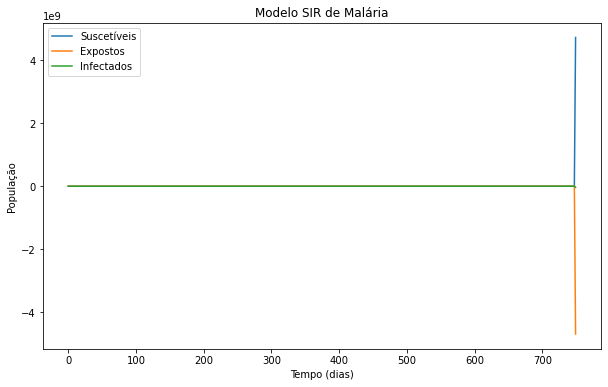

In [55]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

##### Diminuindo $B$, a população novamente tomou valores inadequados. Sendo assim, serão usados os valores $A = -1.5, B = 50.31, C = -1.4, R_L = 400$.

0.8524785585819392
0.43865595143373526
0.8051186386607202
 
0.8524783201917349
0.43865583255463864
0.8051184135144162
 
0.852477304639079
0.43865532612438035
0.8051174543813522
 
0.852476677661386
0.4386550134664619
0.8051168622357533
 
0.8524757371870181
0.4386545444755329
0.8051159740099614
 
0.8524718440990695
0.43865260308854365
0.8051122972046766
 
0.8524706119165103
0.43865198862884547
0.8051111334767039
 
0.8524725986457444
0.4386529793626063
0.8051130098320919
 
0.8524712232222776
0.4386522934723131
0.8051117108210399
 
0.8524630313952862
0.4386482083992257
0.805103974095548
 
0.8524642541012727
0.438648818135039
0.8051051288734241
 
0.8524581229443492
0.4386457606627847
0.8050993383363296
 
0.8524547165735977
0.43864406197784056
0.8050961212083977
 
0.8524547165735977
0.43864406197784056
0.8050961212083977
 
0.8524761746527328
0.4386547626287114
0.8051163871720254
 
0.8524737906631644
0.43865357379245057
0.8051141356263217
 
0.8524600153193159
0.43864670434909714
0.80510112557

0.07682651895680612
0.039753136104759584
0.07255837901476132
 
0.10093959863247415
0.05231488786291274
0.09533184315289225
 
0.11515601246894526
0.059712261442629054
0.10875845622067051
 
0.0937584007437237
0.048578146804521626
0.08854960070240571
 
0.1077224913805799
0.055844211795637366
0.10173790852610323
 
0.2615638490834657
0.13599867781980485
0.24703252413438423
 
0.23212060446438865
0.12064175203384633
0.21922501532747812
 
0.39411013307863346
0.20520620931933323
0.372215125685376
 
0.4928652292073729
0.25683093754812364
0.465483827584741
 
0.4928652292073729
0.25683093754812364
0.465483827584741
 
0.07657957577093176
0.03959629605166655
0.07232515489476889
 
0.07596266577681725
0.03928690291820234
0.07174251767810516
 
0.07633096447629172
0.03949172703103306
0.07209035533871995
 
0.09422386969654492
0.04882037124515186
0.08898921026895908
 
0.1052404416425753
0.05455272667718502
0.09939375044021
 
0.088724916176188
0.045958441937289804
0.08379575416639977
 
0.09946253730389103


0.7344782531878375
0.38218551224496133
0.6936739057885131
 
0.7854751424856028
0.4079167948443479
0.7418376345697358
 
0.7912519076284273
0.41083066179961825
0.747293468315737
 
0.8000469535424038
0.4152640015499133
0.7555999005678257
 
0.8365351165904354
0.4335959472988363
0.7900609434465223
 
0.8475053288344306
0.43907806505622526
0.8004216994547398
 
0.829604748083054
0.4301240410438137
0.783515595411773
 
0.8421250402175019
0.43639169824661406
0.7953403157609739
 
0.8955333051053925
0.4625590321052358
0.8457814548217595
 
0.890928356032819
0.4604120658501386
0.8414323362532178
 
0.8971224819100776
0.4624312019139734
0.8472823440261843
 
0.8799603137750308
0.45293702552688336
0.8310736296764181
 
0.8799603137750308
0.45293702552688336
0.8310736296764181
 
0.79594022670095
0.41319441058513
0.7517213252175637
 
0.8184456709858708
0.4245225478792008
0.7729764670422112
 
0.899962428500853
0.4642634971292756
0.849964515806361
 
0.8685964982294196
0.44683443905665793
0.8203411372166739
 


 
0.8196673021019273
0.41740709142144833
0.7741302297629312
 
0.34263421031855895
0.17451246458420108
0.3235989764119723
 
0.401319267638583
0.20434178220400628
0.3790237527697728
 
0.7295960844174694
0.37135968884937326
0.6890629686164986
 
0.8381875793293324
0.4269170422872291
0.791621602699925
 
0.8465468600961773
0.4312181620427232
0.799516478979723
 
0.8579427833785985
0.4370937913121899
0.8102792954131207
 
0.89041166240259
0.4539993785229672
0.8409443478246682
 
0.8958228713789069
0.4568937657506151
0.8460549340800787
 
0.8859598879720979
0.45165204632057826
0.83673989419587
 
0.8934235950330777
0.45560197017352655
0.8437889508645733
 
0.8838562025816059
0.4517962657129903
0.834753080215961
 
0.8903768116057759
0.4549458857867088
0.8409114331832325
 
0.8456302392365028
0.43301913935902014
0.7986507815011414
 
0.8126037039279046
0.416664698835016
0.7674590537096876
 
0.8126037039279046
0.416664698835016
0.7674590537096876
 
0.8528133012575291
0.4344471027596937
0.8054347845209997

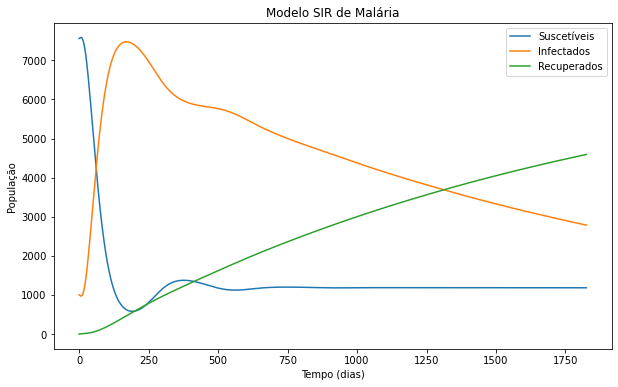

In [56]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, -1.5, 45.31, -1.4, b2, tau_H, DD, Tmin, gamma, 400,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

0.8524785585819392
0.43865595143373526
0.8051186386607202
 
0.8524783201917349
0.43865583255463864
0.8051184135144162
 
0.852477304639079
0.43865532612438035
0.8051174543813522
 
0.852476677661386
0.4386550134664619
0.8051168622357533
 
0.8524757371870181
0.4386545444755329
0.8051159740099614
 
0.8524718440990695
0.43865260308854365
0.8051122972046766
 
0.8524706119165103
0.43865198862884547
0.8051111334767039
 
0.8524725986457444
0.4386529793626063
0.8051130098320919
 
0.8524712232222776
0.4386522934723131
0.8051117108210399
 
0.8524630313952862
0.4386482083992257
0.805103974095548
 
0.8524642541012727
0.438648818135039
0.8051051288734241
 
0.8524581229443492
0.4386457606627847
0.8050993383363296
 
0.8524547165735977
0.43864406197784056
0.8050961212083977
 
0.8524547165735977
0.43864406197784056
0.8050961212083977
 
0.8524761746527328
0.4386547626287114
0.8051163871720254
 
0.8524737906631644
0.43865357379245057
0.8051141356263217
 
0.8524600153193159
0.43864670434909714
0.80510112557

0.8661090383973936
0.4462812702287898
0.8179918695975383
 
0.7710472806275933
0.39557506534766346
0.7282113205927269
 
0.7851238743972819
0.40304914514827755
0.7415058813752106
 
0.7268640989916851
0.3720249002794952
0.6864827601588137
 
0.7135034020126543
0.36465060928461346
0.6738643241230622
 
0.7135034020126543
0.36465060928461346
0.6738643241230622
 
0.8999252376679594
0.46532969941215646
0.8499293911308505
 
0.8999795769412432
0.4652572853050152
0.8499807115556184
 
0.8994208213469395
0.46481693503313276
0.8494529979387762
 
0.8895937357407102
0.45910998556837507
0.8401718615328927
 
0.8842393040206366
0.4561470727876605
0.8351148982417121
 
0.892376249648982
0.46066898840687837
0.8427997913351495
 
0.8870171154245088
0.4576794295961717
0.8377383867898137
 
0.8348256944186843
0.4294962515983959
0.7884464891732017
 
0.8441609753083156
0.434487125615935
0.7972631433467423
 
0.7957218206510046
0.4086778264773835
0.7515150528370598
 
0.7696214042146095
0.3948179168525877
0.7268646595

0.0787256547316948
0.04024293104163382
0.07435200724660064
 
0.07612204844004339
0.03894031407296731
0.07189304574892985
 
0.22900278368235477
0.11771624654739551
0.21628040681111277
 
0.3806723636209678
0.19618996318098178
0.35952389897535836
 
0.39844979778345957
0.20540988181884287
0.37631369790660063
 
0.42538068805930734
0.21938592271051655
0.401748427611568
 
0.537654006852902
0.27777051401658803
0.5077843398055184
 
0.5725097217379925
0.2959378420745678
0.5407036260858817
 
0.5160341954662018
0.26651222494238974
0.48736562905141273
 
0.555299260376011
0.2869648773598456
0.5244493014662326
 
0.7608656186136842
0.394542766644662
0.7185953064684794
 
0.7346534352269326
0.38076651878951345
0.693839355492103
 
0.8446147087463833
0.4387645209814349
0.7976916693715841
 
0.8805373523066445
0.457936185609552
0.8316186105118307
 
0.8805373523066445
0.457936185609552
0.8316186105118307
 
0.41282046047131404
0.21286633824021622
0.3898859904451299
 
0.48163045363923007
0.24861240288924322
0.

0.8501313975441971
0.4418395629147268
0.8029018754584081
 
0.8331203300460994
0.43281567106127755
0.7868358672657604
 
0.8593129195470284
0.4467232062551685
0.8115733129055268
 
0.8418706657990427
0.43745406766656164
0.7951000732546514
 
0.6783413823346186
0.3513796439719475
0.6406557499826953
 
0.7084503324449835
0.36716063649909486
0.6690919806424843
 
0.54412578050424
0.28126193709057185
0.5138965704762266
 
0.44455723072376735
0.22944411761449016
0.4198596067946691
 
0.44455723072376735
0.22944411761449016
0.4198596067946691
 
0.889956948331246
0.4631598768487611
0.8405148956461765
 
0.8718874935659325
0.4534332810305867
0.8234492994789362
 
0.5978855155332989
0.3093069273667871
0.5646696535592267
 
0.3875721101549049
0.1998551484062984
0.3660403262574101
 
0.3596470397391334
0.18537256999951793
0.33966664864251483
 
0.3188846696644527
0.16425241533152682
0.30116885468309423
 
0.17426477928784923
0.0895157793343934
0.16458340266074645
 
0.1398662774320962
0.0717857992798539
0.13209

 
0.8872343689419188
0.45156055367553616
0.8379435706673677
 
0.8921587561816504
0.4540907639956567
0.8425943808382252
 
0.8582392656615834
0.4367818730374899
0.8105593064581619
 
0.8321638966613011
0.42356163189246415
0.7859325690690065
 
0.8321638966613011
0.42356163189246415
0.7859325690690065
 
0.8700368049835969
0.4434220640370023
0.8217014269289525
 
0.8859739933121409
0.45137211566702656
0.8367532159059107
 
0.8709317161601164
0.44323617425188955
0.8225466208178875
 
0.8187629021856594
0.41678290824532493
0.7732760742864561
 
0.8119794702444021
0.4133552291784395
0.7668694996752685
 
0.8017992018897531
0.4082157266973894
0.7572548017847667
 
0.7619196316430041
0.3881456261275247
0.7195907632183927
 
0.7508629538730789
0.38260665963016527
0.7091483453245745
 
0.7691555967202877
0.39177808813362347
0.726424730235827
 
0.7562209498506808
0.3852888346453417
0.7142086748589762
 
0.7131089507721603
0.36410936797025595
0.6734917868403736
 
0.7150269178222196
0.36494768521655846
0.67530

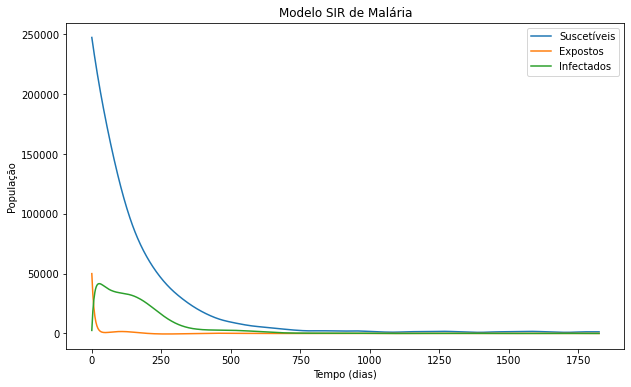

In [57]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [58]:
np.exp(-1/(-1.5*T1^2+45.31*T1-1.4))

0.9933264176331954

In [59]:
# Entrou em loop, não parou de eexcutar

# args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
#                    B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
#                    D1, b1, -1.5, 39.31, -1.4, b2, tau_H, DD, Tmin, gamma, 400,
#                    N, M, E_M0, I_H0, I_M0)

# t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
# sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
# #sol

# times = sol.t
# S_H, I_H, R_H, S_M, E_M, I_M = sol.y

# plt.figure(figsize=(10, 6))
# plt.plot(times, S_H, label='Suscetíveis')
# plt.plot(times, I_H, label='Infectados')
# plt.plot(times, R_H, label='Recuperados')

# plt.xlabel('Tempo (dias)')
# plt.ylabel('População')
# plt.title('Modelo SIR de Malária')

# plt.legend()

# plt.show()

0.8524785585819392
0.43865595143373526
0.8051186386607202
 
0.8524783201923264
0.4386558325549337
0.8051184135149749
 
0.8524773046421911
0.4386553261259323
0.8051174543842915
 
0.8524766776660543
0.4386550134687898
0.8051168622401623
 
0.8524757371940206
0.438654544479025
0.8051159740165749
 
0.8524718441157347
0.43865260309685417
0.8051122972204161
 
0.8524706119362339
0.43865198863868116
0.8051111334953319
 
0.8524725986605369
0.43865297936998293
0.8051130098460625
 
0.852471223240484
0.4386522934813922
0.8051117108382349
 
0.8524630314338264
0.43864820841844476
0.8051039741319471
 
0.8524642541367776
0.4386488181527445
0.8051051289069565
 
0.8524581229950737
0.4386457606880799
0.8050993383842362
 
0.8524547166327786
0.43864406200735284
0.8050961212642908
 
0.8524547166327786
0.43864406200735284
0.8050961212642908
 
0.8524761746586496
0.43865476263166187
0.8051163871776134
 
0.8524737906749982
0.43865357379835185
0.8051141356374982
 
0.8524600153653429
0.43864670437204983
0.80510112

0.7455951238799529
0.3820451803591498
0.7041731725532886
 
0.7230788256504664
0.3699797280971149
0.682907779780996
 
0.7158696855849991
0.36602022869964707
0.6760991474969436
 
0.7158696855849991
0.36602022869964707
0.6760991474969436
 
0.8223702132783588
0.42285268445191615
0.7766829792073388
 
0.8201498556301896
0.421669875924222
0.7745859747618457
 
0.816809419839302
0.41989111553088526
0.7714311187371186
 
0.8029423456260032
0.41251479293566784
0.7583344375356695
 
0.7985720650064841
0.410192189237505
0.7542069502839016
 
0.8056268906439711
0.4139419380053843
0.7608698411637503
 
0.8007376949035363
0.41134301988360733
0.7562522674088952
 
0.7725677417351768
0.3963824023437932
0.729647311638778
 
0.7766136245370223
0.3985305757316979
0.7334684231738543
 
0.7571766281474007
0.38820691559509285
0.7151112599169894
 
0.7474783145793804
0.38304808688994724
0.7059517415471925
 
0.7474783145793804
0.38304808688994724
0.7059517415471925
 
0.8183645005194912
0.42071908128687147
0.77289980604

 
0.7932175863614828
0.40394014362405556
0.7491499426747336
 
0.7932175863614828
0.40394014362405556
0.7491499426747336
 
0.7863067052969934
0.4004617100521308
0.7426229994471605
 
0.7864654165900967
0.40054156022049575
0.7427728934462025
 
0.7867036134003234
0.4006614038629312
0.7429978571003053
 
0.7876912286015779
0.40115834016473795
0.7439306047903791
 
0.7880043394496842
0.40131590045387133
0.7442263205913684
 
0.7874996134645786
0.4010619207100255
0.7437496349387687
 
0.787848969020673
0.4012377158348613
0.7440795818528577
 
0.7899359284918952
0.40228802977106537
0.7460505991312343
 
0.7896237732275744
0.402130912715778
0.7457557858260424
 
0.7911912485398757
0.40291992997408593
0.7472361791765492
 
0.7920644018200786
0.4033595121596825
0.7480608239411853
 
0.7920644018200786
0.4033595121596825
0.7480608239411853
 
0.7862654081274251
0.4004409330582909
0.7425839965647902
 
0.7864034454174206
0.4005103813471039
0.7427143651164527
 
0.7866105998847187
0.40061460566229556
0.74291001

 
0.8249109963185183
0.4199260268988274
0.779082607634156
 
0.8252025388068425
0.4200733167882363
0.7793579533175733
 
0.8269357177685037
0.42094902291920433
0.7809948445591421
 
0.8266773866414304
0.4208184888885624
0.7807508651613508
 
0.8279714151248443
0.4214723919952164
0.7819730031734639
 
0.8286888471338544
0.42183496394929765
0.7826505778486401
 
0.8286888471338544
0.42183496394929765
0.7826505778486401
 
0.8241523245497808
0.4195427591446552
0.7783660842970151
 
0.8246582105050578
0.4197983206946853
0.778843865476999
 
0.8275723793190108
0.4212707407370757
0.7815961360235102
 
0.8289527296248201
0.42196833006644874
0.7828998002012189
 
0.8290846138504387
0.4220349856384153
0.7830243575254143
 
0.8292823681370269
0.42213493424463866
0.7832111254627475
 
0.8301000109028939
0.42254820696973583
0.7839833436305107
 
0.8303584697975016
0.4226788506229732
0.7842274436976403
 
0.8299416604286114
0.4224681669812624
0.7838337904047995
 
0.8302302642541602
0.4226140459223312
0.7841063606

 
0.8657843676342013
0.44062247376963776
0.8176852360989677
 
0.8659077369429747
0.4406851178460146
0.8178017515572538
 
0.8657087414489115
0.44058407324482474
0.8176138113684164
 
0.8658465514509841
0.44065404909375
0.8177439652592626
 
0.8666631746681878
0.44106874281820463
0.8185152205199551
 
0.8665417401814389
0.4410070725351057
0.8184005323935811
 
0.8671490458106492
0.4413155057799929
0.8189740988211687
 
0.8674846993968764
0.44148599004697353
0.8192911049859387
 
0.8674846993968764
0.44148599004697353
0.8192911049859387
 
0.8653495146040353
0.440401676719
0.8172745415704776
 
0.8655891466969614
0.44052334798921644
0.8175008607693524
 
0.8669620335403249
0.44122052377835935
0.8187974761214177
 
0.8676177954154555
0.44155359488575796
0.8194168067812635
 
0.8676842690320037
0.44158736017437955
0.8194795874191145
 
0.8677838862810132
0.44163796160012353
0.8195736703765123
 
0.8681950468021971
0.44184682457103236
0.8199619886465193
 
0.868324775338145
0.44191272812891413
0.820084510

0.8942934797960063
0.4551656382081803
0.844610508696228
 
0.8942069076812713
0.45512102202018473
0.8445287461434228
 
0.8942669069466649
0.45515194267650216
0.8445854121162946
 
0.8946181897309577
0.4553330538678516
0.8449171791903488
 
0.8945664184359902
0.4553063535228044
0.8448682840784351
 
0.894823678470786
0.45543906261300177
0.8451112518890755
 
0.8949640729017369
0.4555115193876079
0.8452438466294179
 
0.8949640729017369
0.4555115193876079
0.8452438466294179
 
0.8940495487516068
0.4550399444620585
0.8443801293765175
 
0.8941546729437988
0.4550941058362566
0.84447941333581
 
0.8947449004143235
0.4553984162303559
0.8450368503913054
 
0.8950150644022191
0.4555378419192869
0.8452920052687624
 
0.8950404688140898
0.45555095727482464
0.845315998324418
 
0.8950784611666092
0.45557057287321445
0.8453518799906863
 
0.8952342654435347
0.4556510351599942
0.8454990284744492
 
0.8952830858821097
0.45567625434726916
0.8455451366664368
 
0.8952042524792246
0.4556355329761426
0.845470682897045

0.8497406399758638
 
0.8997371204604623
0.4580687909332734
0.8497517248793254
 
0.8996756626658997
0.4580408948676343
0.849693681406683
 
0.8996387034071989
0.458023977154146
0.8496587754401324
 
0.8996387034071989
0.458023977154146
0.8496587754401324
 
0.8998380278946597
0.45811365856360364
0.8498470263449562
 
0.8998198061851064
0.4581056730775775
0.8498298169526002
 
0.8996953258687386
0.4580498550632359
0.8497122522093641
 
0.8996246219225978
0.4580175079775001
0.8496454762602311
 
0.8996174791604384
0.45801422194626673
0.8496387303181916
 
0.8996066374374658
0.45800922856751924
0.8496284909131621
 
0.8995601295177368
0.45798773718589386
0.8495845667667512
 
0.8995448624587102
0.45798065917042524
0.8495701478776706
 
0.8995693486299525
0.45799200600511486
0.8495932737060663
 
0.8995524695935295
0.45798418727992724
0.8495773323938889
 
0.8994451405751132
0.45793419077970277
0.8494759660987179
 
0.8994619006033159
0.4579420265136784
0.8494917950142427
 
0.8993752400097922
0.457901414

0.8381523868664175
 
0.8865185121215807
0.4515667537537696
0.8372674836703817
 
0.8860606710174365
0.45133881734652015
0.8368350781831344
 
0.8860164672985887
0.4513168072040384
0.8367933302264448
 
0.8859500262475384
0.4512837234624283
0.8367305803448972
 
0.8856732712585244
0.45114590204815574
0.8364692006330507
 
0.8855850985838839
0.4511019883047665
0.8363859264403346
 
0.8857271279172486
0.4511727238769953
0.8365200652551792
 
0.8856288772400467
0.4511237922113359
0.8364272729489329
 
0.8850365302498931
0.4508287297523549
0.8358678341248991
 
0.8851257244216104
0.45087316563381163
0.8359520730648542
 
0.8846757083554102
0.4506489495334437
0.8355270578912207
 
0.8844227069811945
0.45052287106558164
0.8352881121489056
 
0.8844227069811945
0.45052287106558164
0.8352881121489056
 
0.8859809517303094
0.4512991226965476
0.8367597877452921
 
0.8858119970954651
0.45121498896648327
0.8366002194790502
 
0.8848153408896787
0.45071852575036825
0.8356589330624743
 
0.8843290676875752
0.4504762

0.4334546741682685
0.8030941243477093
 
0.8505002957625605
0.4335376981716278
0.803250279331307
 
0.8496684364980532
0.4331199733186703
0.8024646344703835
 
0.8492032769903982
0.4328863728847919
0.8020253171575982
 
0.8492032769903982
0.4328863728847919
0.8020253171575982
 
0.8520978052650674
0.4343397897585145
0.8047590383058969
 
0.8517804172819705
0.43418044460185884
0.8044592829885276
 
0.8499259279074786
0.4332492788589802
0.8027078208015074
 
0.8490312949449401
0.4328000014669585
0.8018628896702212
 
0.848945194278758
0.43275676008430164
0.8017815723743825
 
0.8488159062417052
0.43269182842575943
0.801659467006055
 
0.8482789841470838
0.4324221631063214
0.8011523739166903
 
0.8481084634145228
0.43233651701574954
0.8009913265581603
 
0.8483832670902105
0.43247453969779265
0.8012508633629765
 
0.8481930964930531
0.4323790251937595
0.8010712577989945
 
0.8470532480171508
0.43180648787418197
0.79999473423842
 
0.8472241655140458
0.4318923428347899
0.8001561563188209
 
0.8463643452369

 
0.7865306014306424
0.4013339237605746
0.7428344569067178
 
0.7862434700484515
0.401189095211983
0.7425632772679819
 
0.7845265118962645
0.4003230231050099
0.7409417056798053
 
0.7847835268577944
0.40045267171077775
0.7411844420323613
 
0.7834921286034277
0.39980122294116677
0.7399647881254594
 
0.7827718265171444
0.3994378477060082
0.7392845028217473
 
0.7827718265171444
0.3994378477060082
0.7392845028217473
 
0.7872755735335922
0.40170967699444654
0.7435380416706148
 
0.786779177462725
0.40145930344419783
0.7430692231592401
 
0.7838914147644542
0.4000026479924371
0.7403418917219845
 
0.7825052818396503
0.399303379160536
0.7390327661818917
 
0.7823719053370088
0.39923609170975694
0.7389067994849526
 
0.7821717104404061
0.3991350940917231
0.73871772652705
 
0.7813413665050569
0.3987161784679539
0.7379335128103315
 
0.7810780090992152
0.39858330903236927
0.7376847863714809
 
0.7815025073205835
0.39879747665175397
0.7380857013583287
 
0.7812086979643856
0.39864924455825873
0.73780821474

 
0.7013224951116954
0.358280668519123
0.6623601342721567
 
0.7003632974692457
0.3577952716062438
0.6614542253876208
 
0.7003632974692457
0.3577952716062438
0.6614542253876208
 
0.7063763226307616
0.3608378861538576
0.6671331935957191
 
0.7057117408788461
0.3605016339597166
0.6665055330522436
 
0.7018546127618494
0.35854993747996694
0.6628626898306355
 
0.7000076516090917
0.35761529514462315
0.6611183376308087
 
0.6998297374454396
0.35752525998485973
0.6609503075873596
 
0.6995627522755236
0.35739014864279817
0.6606981549268833
 
0.6984561458862933
0.3568301238492072
0.659653026670388
 
0.6981054227993039
0.3566526279168641
0.6593217881993425
 
0.6986708038201074
0.35693875818931164
0.6598557591634346
 
0.698279450797865
0.3567407012398342
0.6594861479757612
 
0.695942721336218
0.3555580724991338
0.6572792368175391
 
0.6962921377507697
0.3557349191406651
0.6576092412090602
 
0.6945377770017994
0.3548469825803553
0.6559523449461437
 
0.6935606711208555
0.3543524178585535
0.6550295227252

 
0.5878522850174874
0.3007658848739189
0.5551938247387381
 
0.5856073274155356
0.2996262035828655
0.5530735870035614
 
0.5843584780447212
0.29899218110455017
0.5518941181533477
 
0.5843584780447212
0.29899218110455017
0.5518941181533477
 
0.5922063066999508
0.30297607312127295
0.5593059563277312
 
0.591336701269155
0.3025346637444476
0.5584846623097575
 
0.5863006253380488
0.29997817205344146
0.5537283683748238
 
0.5838933640045235
0.29875604439347586
0.5514548437820499
 
0.5836607467367332
0.2986379444034135
0.5512351496958035
 
0.5833117457479238
0.29846075498758423
0.5509055376508167
 
0.5818661424134269
0.2977267987727409
0.5495402456126809
 
0.5814082961538685
0.29749433720357055
0.5491078352564313
 
0.5821464396704831
0.29786911233138086
0.5498049707999005
 
0.5816354593699882
0.2976096747671529
0.5493223782938778
 
0.5785883926230847
0.2960625325515614
0.5464445930329133
 
0.5790435983731237
0.2962936699639567
0.5468745095746167
 
0.5767596059084829
0.2951339124241723
0.5447174

 
0.425751972541351
0.21831231052714234
0.4020990851779425
 
0.4227214572469223
0.21676777074792763
0.39923693184431536
 
0.4210390092911381
0.2159102423814759
0.3976479532194081
 
0.4210390092911381
0.2159102423814759
0.3976479532194081
 
0.431651811305642
0.2213189187714801
0.4076711551219951
 
0.4304711316201025
0.2207172679268877
0.4065560687523189
 
0.4236565176260636
0.21724434771489953
0.40012004442461563
 
0.4204028640914101
0.21558599607553705
0.39704714941966496
 
0.42008483897129345
0.21542389529116235
0.39674679236177707
 
0.4196078612192904
0.21518077237110134
0.39629631337377424
 
0.41763424461891874
0.21417476033113284
0.3944323421400898
 
0.41700986854677957
0.21385648717689804
0.393842653627514
 
0.4180166593083924
0.21436969233279943
0.3947935115690372
 
0.4173196143547336
0.21401437942682802
0.39413519133502606
 
0.41317175911062076
0.21189992308787445
0.390217772493364
 
0.41379045866871156
0.2122153313769145
0.3908020998537831
 
0.4106895307515414
0.210634455585377

 
0.21018355931003457
0.10816047264936955
0.19850669490392148
 
0.21138180428365871
0.10877443484304074
0.1996383707123443
 
0.20541590855405564
0.10571740183405509
0.19400391363438585
 
0.20214783039625056
0.10404256615710371
0.1909173953742366
 
0.20214783039625056
0.10404256615710371
0.1909173953742366
 
0.22328053491193658
0.1148700713327963
0.21087606075016227
 
0.22086991946638457
0.11363528901660518
0.20859936838491872
 
0.20724587683487622
0.10665516408626645
0.19573221701071636
 
0.20049600364408893
0.10319597473469669
0.18935733677497282
 
0.19967337860491233
0.10277434986901063
0.18858041312686166
 
0.19844357095831902
0.10214401130579259
0.18741892812730127
 
0.1934061142103567
0.09956183443482923
0.18266133008755905
 
0.19182980495076063
0.09875375085800617
0.18117259356460721
 
0.1943757036929639
0.10005886975323557
0.1835770534877992
 
0.19261074361881164
0.09915409790262111
0.18191014675109982
 
0.1823271904297546
0.09388154368431051
0.17219790207254598
 
0.183836965846

 
0.08107827301888872
0.04189678609768817
0.07657392451783933
 
0.08271485111029526
0.042736404033301936
0.07811958160416775
 
0.08252200621956515
0.042637440760763354
0.0779374503184782
 
0.08146163151721646
0.04209340858337382
0.07693598532181552
 
0.08098952485189274
0.04185127316696016
0.07649010680456537
 
0.08094543699709182
0.04182866430675173
0.07644846827503114
 
0.08087966306411379
0.0417949355590725
0.0763863484494408
 
0.0806119685154674
0.041657675647644464
0.07613352582016365
 
0.08052877808974174
0.04161502449100441
0.07605495708475608
 
0.0806632762340277
0.04168398187402417
0.07618198310991504
 
0.08056995785891774
0.04163613679183921
0.07609384908897784
 
0.08003324301608494
0.04136101726543578
0.07558695173741355
 
0.08011127777550615
0.04140101116158569
0.07566065123242247
 
0.0797273114155121
0.041204247530671874
0.07529801633687254
 
0.07952190457486531
0.04109901389677742
0.07510402098737279
 
0.07952190457486531
0.04109901389677742
0.07510402098737279
 
0.081036

0.07503451317104151
 
0.07944726183152602
0.04106077823669036
0.07503352506310788
 
0.07944103412746127
0.041057588232407814
0.0750276433426023
 
0.07944196328889003
0.04105806417360403
0.07502852088395168
 
0.07943730543213852
0.04105567830004046
0.07502412179701971
 
0.07943471905536713
0.0410543534965048
0.07502167910784673
 
0.07943471905536713
0.0410543534965048
0.07502167910784673
 
0.07945232929158948
0.04106337394646771
0.07503831099761227
 
0.07945207219434171
0.041063242252983384
0.07503806818354493
 
0.07945168656587702
0.04106304472173781
0.07503770397888383
 
0.07945009052234984
0.041062227177969327
0.07503619660444151
 
0.07944958545459821
0.041061968466634256
0.07503571959600941
 
0.07945039982961988
0.04106238561479224
0.07503648872797432
 
0.07944983602160065
0.04106209681479176
0.07503595624262283
 
0.07944647915690756
0.04106037732773715
0.07503278587041269
 
0.07944698008088928
0.041060633915692854
0.07503325896528433
 
0.07944446866018075
0.04105934749366346
0.0750

0.07943169947026882
0.04105280679783113
0.07501882727747611
 
0.07943169947026882
0.04105280679783113
0.07501882727747611
 
0.07943173337772236
0.04105282416595667
0.07501885930118221
 
0.07943172961021952
0.041052822236160816
0.07501885574298509
 
0.0794317078424641
0.041052811086249204
0.07501883518454942
 
0.07943169748856586
0.04105280578276035
0.07501882540586775
 
0.07943169649771391
0.0410528052752247
0.07501882447006313
 
0.07943169501143765
0.04105280451392213
0.07501882306635779
 
0.079431688859166
0.0410528013625966
0.07501881725587899
 
0.07943168691199366
0.04105280036521316
0.07501881541688289
 
0.07943169005156062
0.0410528019733667
0.07501881838202948
 
0.07943168787801452
0.04105280086002978
0.07501881632923592
 
0.07943167493335211
0.04105279422949605
0.07501880410372143
 
0.07943167686538948
0.04105279521912702
0.07501880592842339
 
0.07943166717760669
0.04105279025683695
0.07501879677885075
 
0.07943166179551092
0.041052787500012115
0.0750187916957603
 
0.0794316617

0.0794316561340364
0.041052784600083506
0.07501878634881215
 
0.07943165600530419
0.0410527845341441
0.07501878622723171
 
0.07943165593378679
0.04105278449751137
0.07501878615968749
 
0.07943165593378679
0.04105278449751137
0.07501878615968749
 
0.0794316563843483
0.04105278472829863
0.07501878658521782
 
0.07943165633428603
0.04105278470265565
0.07501878653793678
 
0.0794316560450363
0.04105278455449574
0.0750187862647565
 
0.07943165590745356
0.04105278448402292
0.07501878613481724
 
0.07943165589428719
0.041052784477278816
0.07501878612238234
 
0.07943165587453739
0.041052784467162554
0.07501878610372975
 
0.07943165579278556
0.04105278442528752
0.0750187860265197
 
0.07943165576691152
0.04105278441203428
0.0750187860020831
 
0.07943165580863083
0.0410527844334038
0.07501878604148465
 
0.07943165577974864
0.04105278441860973
0.07501878601420704
 
0.07943165560773885
0.04105278433050262
0.07501878585175333
 
0.0794316556334121
0.04105278434365302
0.07501878587600032
 
0.079431655504

0.07943165535002138
0.0410527841984942
0.0750187856083535
 
0.07943165534974488
0.04105278419835257
0.07501878560809237
 
0.07943165534974488
0.04105278419835257
0.07501878560809237
 
0.07943165535148684
0.04105278419924486
0.07501878560973757
 
0.07943165535129292
0.041052784199145514
0.07501878560955441
 
0.07943165535017475
0.04105278419857278
0.07501878560849838
 
0.07943165534964278
0.04105278419830028
0.07501878560799595
 
0.07943165534959198
0.04105278419827426
0.07501878560794796
 
0.07943165534951578
0.041052784198235236
0.075018785607876
 
0.07943165534919973
0.04105278419807334
0.07501878560757749
 
0.07943165534909959
0.041052784198022045
0.07501878560748293
 
0.07943165534926079
0.04105278419810461
0.07501878560763517
 
0.07943165534914941
0.04105278419804756
0.07501878560752998
 
0.07943165534848408
0.04105278419770677
0.07501878560690162
 
0.07943165534858324
0.04105278419775757
0.07501878560699526
 
0.07943165534808497
0.04105278419750234
0.07501878560652468
 
0.0794316

0.0794316553474895
0.04105278419719733
0.0750187856059623
 
0.07943165534748756
0.04105278419719633
0.07501878560596045
 
0.07943165534748657
0.04105278419719583
0.07501878560595952
 
0.07943165534748657
0.04105278419719583
0.07501878560595952
 
0.07943165534749341
0.041052784197199335
0.07501878560596599
 
0.07943165534749244
0.04105278419719883
0.07501878560596506
 
0.07943165534748803
0.04105278419719658
0.07501878560596091
 
0.0794316553474856
0.04105278419719532
0.07501878560595861
 
0.0794316553474856
0.04105278419719533
0.07501878560595861
 
0.0794316553474856
0.04105278419719533
0.07501878560595861
 
0.07943165534748461
0.04105278419719483
0.07501878560595768
 
0.07943165534748364
0.041052784197194325
0.07501878560595678
 
0.07943165534748461
0.04105278419719483
0.07501878560595768
 
0.07943165534748364
0.04105278419719432
0.07501878560595678
 
0.07943165534748217
0.041052784197193576
0.07501878560595539
 
0.07943165534748217
0.041052784197193576
0.07501878560595539
 
0.0794316

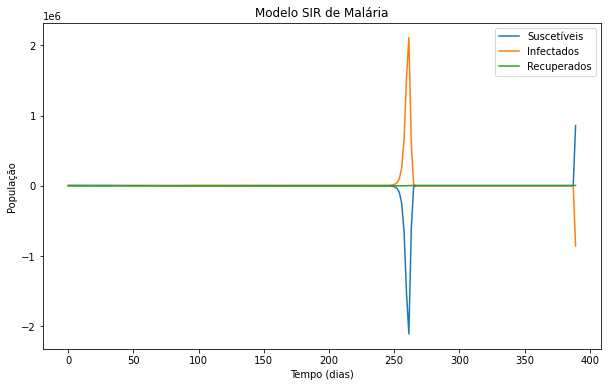

In [60]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, -1.5, 35.31, -1.4, b2, tau_H, DD, Tmin, gamma, 400,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

0.8524785585819392
0.43865595143373526
0.8051186386607202
 
0.8524783201923264
0.4386558325549337
0.8051184135149749
 
0.8524773046421911
0.4386553261259323
0.8051174543842915
 
0.8524766776660543
0.4386550134687898
0.8051168622401623
 
0.8524757371940206
0.438654544479025
0.8051159740165749
 
0.8524718441157347
0.43865260309685417
0.8051122972204161
 
0.8524706119362339
0.43865198863868116
0.8051111334953319
 
0.8524725986605369
0.43865297936998293
0.8051130098460625
 
0.852471223240484
0.4386522934813922
0.8051117108382349
 
0.8524630314338264
0.43864820841844476
0.8051039741319471
 
0.8524642541367776
0.4386488181527445
0.8051051289069565
 
0.8524581229950737
0.4386457606880799
0.8050993383842362
 
0.8524547166327786
0.43864406200735284
0.8050961212642908
 
0.8524547166327786
0.43864406200735284
0.8050961212642908
 
0.8524761746586496
0.43865476263166187
0.8051163871776134
 
0.8524737906749982
0.43865357379835185
0.8051141356374982
 
0.8524600153653429
0.43864670437204983
0.80510112

0.7430455083723071
0.38068653500820837
0.7017652023516232
 
0.7388655695447329
0.37845659479843513
0.6978174823478033
 
0.7203657020946683
0.36850394927623786
0.680345385311631
 
0.7153529232710542
0.36572845146734334
0.67561109420044
 
0.7150105587413541
0.3655337260691569
0.6752877499223898
 
0.7145427787340753
0.36526524144339034
0.6748459576932933
 
0.7131953663543118
0.3644574730173393
0.67357340155685
 
0.7129678970169657
0.3643043511395606
0.673358569404912
 
0.7133820295641484
0.3645756433909084
0.6737496945883623
 
0.7130687442576332
0.36437413364908144
0.673453814021098
 
0.7136842354103298
0.36445171262386167
0.6740351112208669
 
0.7133228517044734
0.3643014142330856
0.6736938043875581
 
0.7160760367060622
0.365539146311319
0.6762940346668364
 
0.7186069753708554
0.3667417383775673
0.67868436562803
 
0.7186069753708554
0.3667417383775673
0.67868436562803
 
0.71547614789507
0.36579824012357154
0.6757274730120105
 
0.7151839318185012
0.36563249596899544
0.6754514911619176
 
0.

0.7925230948649675
0.4035904558661802
0.748494034039136
 
0.7928129755185362
0.4037364120172662
0.7487678102119508
 
0.7945427152493845
0.4046074461978303
0.7504014532910852
 
0.7942841944086504
0.40447725336426793
0.7501572947192808
 
0.7955816617767085
0.405130705636449
0.7513826805668914
 
0.7963036928745595
0.40549438893860357
0.7520645988259728
 
0.7963036928745595
0.40549438893860357
0.7520645988259728
 
0.7914964158248633
0.40307355884573076
0.7475243927234819
 
0.7916102021842716
0.4031308431909435
0.7476318576184787
 
0.7917809330102805
0.40321679698769497
0.7477931033985982
 
0.7924882973456041
0.4035729355013486
0.7484611697152928
 
0.7927123873614145
0.4036857648846787
0.7486728102857801
 
0.7923511205077176
0.4035038683987425
0.7483316138128443
 
0.7926012005059375
0.4036297819004466
0.7485678004778298
 
0.7940930930135652
0.4043810159156308
0.7499768100683669
 
0.7938701556491464
0.4042687487664033
0.7497662581130826
 
0.7949889256017514
0.40483216984524867
0.750822874179

0.8289527296248201
0.42196833006644874
0.7828998002012189
 
0.8290846138504387
0.4220349856384153
0.7830243575254143
 
0.8292823681370269
0.42213493424463866
0.7832111254627475
 
0.8301000109028939
0.42254820696973583
0.7839833436305107
 
0.8303584697975016
0.4226788506229732
0.7842274436976403
 
0.8299416604286114
0.4224681669812624
0.7838337904047995
 
0.8302302642541602
0.4226140459223312
0.7841063606844846
 
0.8319448955490812
0.4234808192417211
0.7857257346852433
 
0.8316894465301328
0.4233516760929613
0.7854844772784587
 
0.8329686212071412
0.4239984013073142
0.7866925866956332
 
0.8336773669145582
0.4243567656786124
0.787361957641527
 
0.8336773669145582
0.4243567656786124
0.787361957641527
 
0.8289246511499017
0.42195413904637746
0.7828732816415737
 
0.8290425076883771
0.42201370467760313
0.7829845905945781
 
0.8292192351047862
0.422103025447076
0.7831514998211869
 
0.8299500321367218
0.422472398521003
0.783841697018015
 
0.830181071351453
0.4225891803623954
0.7840599007208167


0.44062247376963776
0.8176852360989677
 
0.8659077369429747
0.4406851178460146
0.8178017515572538
 
0.8657087414489115
0.44058407324482474
0.8176138113684164
 
0.8658465514509841
0.44065404909375
0.8177439652592626
 
0.8666631746681878
0.44106874281820463
0.8185152205199551
 
0.8665417401814389
0.4410070725351057
0.8184005323935811
 
0.8671490458106492
0.4413155057799929
0.8189740988211687
 
0.8674846993968764
0.44148599004697353
0.8192911049859387
 
0.8674846993968764
0.44148599004697353
0.8192911049859387
 
0.8653495146040353
0.440401676719
0.8172745415704776
 
0.8655891466969614
0.44052334798921644
0.8175008607693524
 
0.8669620335403249
0.44122052377835935
0.8187974761214177
 
0.8676177954154555
0.44155359488575796
0.8194168067812635
 
0.8676842690320037
0.44158736017437955
0.8194795874191145
 
0.8677838862810132
0.44163796160012353
0.8195736703765123
 
0.8681950468021971
0.44184682457103236
0.8199619886465193
 
0.868324775338145
0.44191272812891413
0.8200845100415813
 
0.868115508

0.4545305303230311
0.8434453964414902
 
0.893703672260652
0.45486182006171066
0.844053468246171
 
0.893999415517753
0.45501411902624866
0.8443327813223221
 
0.8940272563947298
0.4550284605601681
0.8443590754839113
 
0.8940689047364486
0.4550499160914942
0.8443984100288681
 
0.8942398589730743
0.4551380030254166
0.8445598668079034
 
0.8942934797960063
0.4551656382081803
0.844610508696228
 
0.8942069076812713
0.45512102202018473
0.8445287461434228
 
0.8942669069466649
0.45515194267650216
0.8445854121162946
 
0.8946181897309577
0.4553330538678516
0.8449171791903488
 
0.8945664184359902
0.4553063535228044
0.8448682840784351
 
0.894823678470786
0.45543906261300177
0.8451112518890755
 
0.8949640729017369
0.4555115193876079
0.8452438466294179
 
0.8949640729017369
0.4555115193876079
0.8452438466294179
 
0.8940495487516068
0.4550399444620585
0.8443801293765175
 
0.8941546729437988
0.4550941058362566
0.84447941333581
 
0.8947449004143235
0.4553984162303559
0.8450368503913054
 
0.8950150644022191

0.8998380278946597
0.45811365856360364
0.8498470263449562
 
0.8998198061851064
0.4581056730775775
0.8498298169526002
 
0.8996953258687386
0.4580498550632359
0.8497122522093641
 
0.8996246219225978
0.4580175079775001
0.8496454762602311
 
0.8996174791604384
0.45801422194626673
0.8496387303181916
 
0.8996066374374658
0.45800922856751924
0.8496284909131621
 
0.8995601295177368
0.45798773718589386
0.8495845667667512
 
0.8995448624587102
0.45798065917042524
0.8495701478776706
 
0.8995693486299525
0.45799200600511486
0.8495932737060663
 
0.8995524695935295
0.45798418727992724
0.8495773323938889
 
0.8994451405751132
0.45793419077970277
0.8494759660987179
 
0.8994619006033159
0.4579420265136784
0.8494917950142427
 
0.8993752400097922
0.45790141407316304
0.8494099488981369
 
0.8993242624368176
0.45787742293503536
0.84936180341255
 
0.8993242624368176
0.45787742293503536
0.84936180341255
 
0.8996116995455551
0.45801156085761024
0.8496332717930241
 
0.8995837117965673
0.4579986484354245
0.84960683

0.8850365302498931
0.4508287297523549
0.8358678341248991
 
0.8851257244216104
0.45087316563381163
0.8359520730648542
 
0.8846757083554102
0.4506489495334437
0.8355270578912207
 
0.8844227069811945
0.45052287106558164
0.8352881121489056
 
0.8844227069811945
0.45052287106558164
0.8352881121489056
 
0.8859809517303094
0.4512991226965476
0.8367597877452921
 
0.8858119970954651
0.45121498896648327
0.8366002194790502
 
0.8848153408896787
0.45071852575036825
0.8356589330624743
 
0.8843290676875752
0.4504762035883431
0.8351996750382654
 
0.8842821394166711
0.4504528148907064
0.8351553538935225
 
0.8842116112122782
0.45041766313577747
0.835088743922707
 
0.8839179338188096
0.4502712791374226
0.8348113819399867
 
0.8838244039098822
0.4502246546130399
0.834723048137111
 
0.883975070782146
0.4502997607965893
0.8348653446275821
 
0.8838708404483757
0.450247803422346
0.8347669048679102
 
0.8832428650301729
0.44993471210976155
0.8341738169729409
 
0.8833373786033546
0.4499818398311783
0.8342630797920

0.8424549009633966
0.42949609665150557
0.7956518509098744
 
0.8455455246661628
0.43104906528868525
0.7985707732958204
 
0.8452063384021484
0.43087865502115463
0.7982504307131401
 
0.843225950407258
0.4298835754119222
0.7963800642735214
 
0.8422714111200741
0.4294038825197901
0.7954785549467365
 
0.8421795568251049
0.4293577198853013
0.7953918036681545
 
0.8420416386877383
0.429288406483009
0.7952615476495304
 
0.841468997766698
0.42900060520235805
0.7947207201129923
 
0.8412871737071904
0.4289092197617927
0.7945489973901242
 
0.8415802029317275
0.4290564965636257
0.794825747213298
 
0.8413774144353373
0.42895457527678255
0.7946342247444851
 
0.8401624398199343
0.42834389025490116
0.7934867487188266
 
0.8403445678602405
0.42843543796090455
0.7936587585346715
 
0.8394285433766207
0.42797497766694187
0.7927936243001417
 
0.8389166388164986
0.4277176407992442
0.7923101588822485
 
0.8389166388164986
0.4277176407992442
0.7923101588822485
 
0.8421058121370718
0.42932065819174375
0.79532215590

 
0.7813413665050569
0.3987161784679539
0.7379335128103315
 
0.7810780090992152
0.39858330903236927
0.7376847863714809
 
0.7815025073205835
0.39879747665175397
0.7380857013583287
 
0.7812086979643856
0.39864924455825873
0.7378082147441418
 
0.7794520093080454
0.39776292170133554
0.7361491199020427
 
0.7797149497325779
0.3978955906861145
0.7363974525252124
 
0.7783938555808927
0.3972290045184556
0.7351497524930651
 
0.7776570733282901
0.39685722797711187
0.7344539025878295
 
0.7776570733282901
0.39685722797711187
0.7344539025878295
 
0.7822648511354452
0.39918208336057237
0.7388056927390315
 
0.7817568724878228
0.39892580681315026
0.7383259351273881
 
0.7788023028409904
0.3974350995588692
0.735535508238713
 
0.7773844031639466
0.39671963687455686
0.7341963807659495
 
0.7772479645422039
0.39665078844188634
0.7340675220676369
 
0.7770431772506537
0.3965474497234986
0.7338741118478396
 
0.7761938336972795
0.3961188481735829
0.7330719540474304
 
0.775924466392208
0.39598291480035164
0.73281

0.686631072490992
0.35084455528126524
0.6484849017970479
 
0.686631072490992
0.35084455528126524
0.6484849017970479
 
0.692871574671531
0.35400362085160875
0.6543787094120015
 
0.6921816132617092
0.3536543785733038
0.6537270791916142
 
0.6881783555562393
0.351627876908667
0.6499462246920038
 
0.6862619416219202
0.3506576750372649
0.6481362781984801
 
0.6860772877294559
0.3505641893442
0.6479618828555971
 
0.6858001964460332
0.35042390390471906
0.6477001855323645
 
0.6846518016019943
0.34984248337546303
0.6466155904018834
 
0.6842878676954136
0.34965822314948786
0.6462718750456683
 
0.6848745530694655
0.3499552617410384
0.6468259667878284
 
0.6844684488637176
0.34974965189138646
0.6464424239268443
 
0.6820440572479567
0.3485221341613426
0.6441527207341812
 
0.682406536807278
0.3487056704820957
0.644495062540207
 
0.6805867479878612
0.3477842263632768
0.6427763730996466
 
0.6795733740112612
0.34727108596532374
0.6418192976773021
 
0.6795733740112612
0.34727108596532374
0.6418192976773021

0.5843584780447212
0.29899218110455017
0.5518941181533477
 
0.5922063066999508
0.30297607312127295
0.5593059563277312
 
0.591336701269155
0.3025346637444476
0.5584846623097575
 
0.5863006253380488
0.29997817205344146
0.5537283683748238
 
0.5838933640045235
0.29875604439347586
0.5514548437820499
 
0.5836607467367332
0.2986379444034135
0.5512351496958035
 
0.5833117457479238
0.29846075498758423
0.5509055376508167
 
0.5818661424134269
0.2977267987727409
0.5495402456126809
 
0.5814082961538685
0.29749433720357055
0.5491078352564313
 
0.5821464396704831
0.29786911233138086
0.5498049707999005
 
0.5816354593699882
0.2976096747671529
0.5493223782938778
 
0.5785883926230847
0.2960625325515614
0.5464445930329133
 
0.5790435983731237
0.2962936699639567
0.5468745095746167
 
0.5767596059084829
0.2951339124241723
0.5447174055802337
 
0.5754891589054553
0.29448878045267873
0.5435175389662633
 
0.5754891589054553
0.29448878045267873
0.5435175389662633
 
0.5834740958268588
0.29854318106875727
0.5510588

0.44830226066306267
0.22980186563360924
0.4233965795151147
 
0.4488811355612478
0.23009672636224285
0.423943294696734
 
0.4459789571604065
0.2286184069916192
0.42120234842927273
 
0.4443671684264361
0.22779734587722236
0.41968010351385626
 
0.4443671684264361
0.22779734587722236
0.41968010351385626
 
0.4545272784789511
0.232972482611904
0.42927576300789816
 
0.45339777032495915
0.23239721973915772
0.42820900530690587
 
0.4468745644262976
0.22907462464521128
0.42204819973594765
 
0.4437598468401051
0.22748796213097508
0.4191065220156548
 
0.4434562085158623
0.2273332800361969
0.4188197524872032
 
0.44300077960917317
0.22710126936885297
0.4183896251864413
 
0.44111595979359186
0.22614105272536947
0.4166095175828367
 
0.44051955182991265
0.22583720528791348
0.4160462433949174
 
0.4414812152603435
0.22632713453713152
0.4169544810792132
 
0.44081543044554283
0.22598794485613377
0.41632568430967926
 
0.4368520438480637
0.22396865354603507
0.4125824858565045
 
0.4374433973538294
0.22426995210

0.10816047264936955
0.19850669490392148
 
0.21138180428365871
0.10877443484304074
0.1996383707123443
 
0.20541590855405564
0.10571740183405509
0.19400391363438585
 
0.20214783039625056
0.10404256615710371
0.1909173953742366
 
0.20214783039625056
0.10404256615710371
0.1909173953742366
 
0.22328053491193658
0.1148700713327963
0.21087606075016227
 
0.22086991946638457
0.11363528901660518
0.20859936838491872
 
0.20724587683487622
0.10665516408626645
0.19573221701071636
 
0.20049600364408893
0.10319597473469669
0.18935733677497282
 
0.19967337860491233
0.10277434986901063
0.18858041312686166
 
0.19844357095831902
0.10214401130579259
0.18741892812730127
 
0.1934061142103567
0.09956183443482923
0.18266133008755905
 
0.19182980495076063
0.09875375085800617
0.18117259356460721
 
0.1943757036929639
0.10005886975323557
0.1835770534877992
 
0.19261074361881164
0.09915409790262111
0.18191014675109982
 
0.1823271904297546
0.09388154368431051
0.17219790207254598
 
0.18383696584693704
0.09465572746570

0.08267925764764783
0.04271813786973836
0.07808596555611183
 
0.08236658647003833
0.04255768784229448
0.07779066499948065
 
0.0822691538574331
0.04250769297869087
0.0776986453097979
 
0.08242661400501144
0.042588490181778786
0.07784735767139969
 
0.08231739981408255
0.04253244884480567
0.07774421093552239
 
0.08168592896670787
0.04220846615639884
0.07714782180189075
 
0.08177811575861645
0.04225575839652648
0.07723488710535997
 
0.0813231550488358
0.042022380453715466
0.07680520199056713
 
0.08107827301888872
0.04189678609768817
0.07657392451783933
 
0.08107827301888872
0.04189678609768817
0.07657392451783933
 
0.08271485111029526
0.042736404033301936
0.07811958160416775
 
0.08252200621956515
0.042637440760763354
0.0779374503184782
 
0.08146163151721646
0.04209340858337382
0.07693598532181552
 
0.08098952485189274
0.04185127316696016
0.07649010680456537
 
0.08094543699709182
0.04182866430675173
0.07644846827503114
 
0.08087966306411379
0.0417949355590725
0.0763863484494408
 
0.08061196

0.07945232929158948
0.04106337394646771
0.07503831099761227
 
0.07945207219434171
0.041063242252983384
0.07503806818354493
 
0.07945168656587702
0.04106304472173781
0.07503770397888383
 
0.07945009052234984
0.041062227177969327
0.07503619660444151
 
0.07944958545459821
0.041061968466634256
0.07503571959600941
 
0.07945039982961988
0.04106238561479224
0.07503648872797432
 
0.07944983602160065
0.04106209681479176
0.07503595624262283
 
0.07944647915690756
0.04106037732773715
0.07503278587041269
 
0.07944698008088928
0.041060633915692854
0.07503325896528433
 
0.07944446866018075
0.04105934749366346
0.07503088706794847
 
0.07944307380994554
0.041058633012617106
0.07502956970939301
 
0.07944307380994554
0.041058633012617106
0.07502956970939301
 
0.07945186593954527
0.04106313660266373
0.0750378733873483
 
0.07945088849937341
0.04106263592677044
0.07503695024940822
 
0.07944524369533978
0.04105974448864568
0.07503161904559867
 
0.0794425602936035
0.04105836997553483
0.07502908472173661
 
0.07

 
0.07943176714909651
0.04105284146438005
0.07501889119636893
 
0.07943172266021267
0.041052818676218066
0.07501884917908971
 
0.07943172930032656
0.041052822077426984
0.07501885545030841
 
0.07943169600496022
0.041052805022825704
0.07501882400468464
 
0.07943167750760166
0.041052795548081875
0.0750188065349571
 
0.07943167750760166
0.041052795548081875
0.0750188065349571
 
0.07943180331625656
0.04105285998997707
0.07501892535424229
 
0.07943180147932218
0.04105285904905978
0.07501892361935983
 
0.07943179872392185
0.04105285763768446
0.0750189210170373
 
0.07943178731826399
0.041052851795461205
0.07501891024502708
 
0.07943178370841668
0.0410528499464198
0.07501890683572685
 
0.0794317895288363
0.04105285292776388
0.07501891233278982
 
0.07943178549931397
0.0410528508637559
0.07501890852712985
 
0.07943176150131875
0.04105283857146689
0.07501888586235658
 
0.07943176508310361
0.04105284040613407
0.07501888924515339
 
0.07943174712302763
0.04105283120659725
0.0750188722828594
 
0.07943

0.0794316558299648
0.04105278444433152
0.07501878606163341
 
0.07943165587755872
0.04105278446871014
0.07501878610658323
 
0.07943165563890814
0.041052784346468196
0.075018785881191
 
0.07943165550632464
0.0410527842785561
0.07501878575597327
 
0.07943165550632464
0.0410527842785561
0.07501878575597327
 
0.07943165640807785
0.041052784740453416
0.07501878660762908
 
0.0794316563949115
0.04105278473370932
0.07501878659519418
 
0.0794316563751622
0.041052784723593305
0.07501878657654205
 
0.07943165629341034
0.04105278468171826
0.07501878649933198
 
0.07943165626753632
0.04105278466846502
0.07501878647489539
 
0.07943165630925463
0.04105278468983404
0.07501878651429603
 
0.07943165628037245
0.04105278467503998
0.07501878648701842
 
0.07943165610836314
0.041052784586933115
0.07501878632456517
 
0.0794316561340364
0.041052784600083506
0.07501878634881215
 
0.07943165600530419
0.0410527845341441
0.07501878622723171
 
0.07943165593378679
0.04105278449751137
0.07501878615968749
 
0.0794316559

0.07501878561330937
 
0.07943165535526876
0.04105278420118203
0.07501878561330937
 
0.07943165536125575
0.04105278420424869
0.07501878561896375
 
0.0794316553605909
0.041052784203908135
0.07501878561833585
 
0.07943165535674743
0.04105278420193944
0.0750187856147059
 
0.07943165535491853
0.041052784201002626
0.07501878561297859
 
0.07943165535474413
0.041052784200913295
0.07501878561281387
 
0.07943165535448181
0.04105278420077893
0.07501878561256613
 
0.0794316553533949
0.041052784200222195
0.07501878561153962
 
0.07943165535305148
0.041052784200046294
0.07501878561121529
 
0.07943165535360544
0.04105278420033004
0.07501878561173846
 
0.07943165535322197
0.04105278420013362
0.0750187856113763
 
0.07943165535093584
0.04105278419896261
0.07501878560921717
 
0.07943165535127727
0.041052784199137514
0.07501878560953965
 
0.07943165534956657
0.04105278419826125
0.07501878560792398
 
0.07943165534861646
0.041052784197774576
0.07501878560702664
 
0.07943165534861646
0.041052784197774576
0.07

 
0.07943165534752028
0.041052784197213095
0.07501878560599136
 
0.07943165534751784
0.04105278419721184
0.07501878560598906
 
0.07943165534752174
0.041052784197213844
0.07501878560599275
 
0.0794316553475193
0.04105278419721259
0.07501878560599044
 
0.0794316553475027
0.04105278419720409
0.07501878560597475
 
0.07943165534750464
0.04105278419720508
0.0750187856059766
 
0.07943165534749244
0.04105278419719883
0.07501878560596506
 
0.0794316553474856
0.04105278419719533
0.07501878560595861
 
0.0794316553474856
0.04105278419719533
0.07501878560595861
 
0.07943165534753249
0.04105278419721935
0.0750187856060029
 
0.07943165534753152
0.04105278419721884
0.07501878560600198
 
0.07943165534753054
0.04105278419721835
0.07501878560600106
 
0.07943165534752615
0.04105278419721609
0.0750187856059969
 
0.07943165534752468
0.04105278419721534
0.07501878560599552
 
0.07943165534752664
0.041052784197216335
0.07501878560599735
 
0.07943165534752566
0.04105278419721585
0.07501878560599644
 
0.07943165

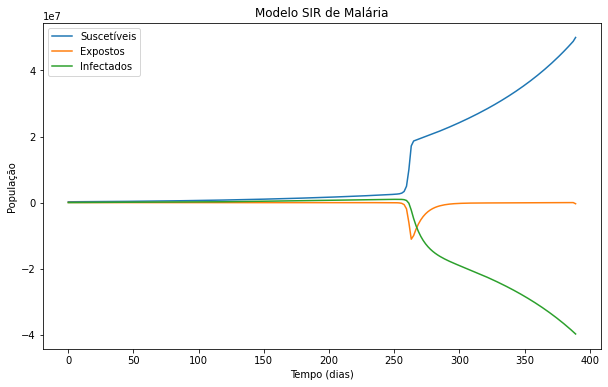

In [61]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

Novamente, diminuir $B$ leva a problemas na modelagem